<a href="https://colab.research.google.com/github/marco-siino/gpt_energy_cost_optimization/blob/main/Mistral7B_Energy_Cost_Optimization_MSiino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download model and libraries.

Installing dependencies. You might need to tweak the CMAKE_ARGS for the `llama-cpp-python` pip package.

In [1]:
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF
!CMAKE_ARGS="-DLLAMA_CUBLAS=on " pip install 'llama-cpp-python>=0.1.79' --force-reinstall --upgrade --no-cache-dir
# For download the models
!pip install huggingface_hub
!pip install datasets

import datasets
from datasets import load_dataset
import json
import re
import random
import numpy as np
import tqdm.notebook as tqdm
from huggingface_hub import hf_hub_download
import tensorflow as tf
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 176.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 197.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 134.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 195.1 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.61-cp310-cp310-manylinux_2_35_x86_64.whl size=38846824 sha256=fe8d7525a15d16a43dfa398e52370e93f29480435d418e777c80b54a0f61ce59
  Stored in directory: /tmp/pip-ephem-wheel-cache-951gb2qr/wheels/a4/d4/bc/483ff5c198ee745418fb35b59055591eeae2bc6ff69680537f
Successfully built llama-cpp-python
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-

Downloading an instruction-finetuned Mistral model.

In [2]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

# This config has been tested on an RTX 3080 (VRAM of 16GB).
# you might need to tweak with respect to your hardware.
from llama_cpp import Llama
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=4, #16, # CPU cores
    n_batch=800, #8000, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=8192, # Context window
    logits_all=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

# Get the dataset.

In [3]:
import requests
import os
import numpy as np
from datetime import datetime
!pip install py7zr
from py7zr import unpack_7zarchive

def download_and_extract(url, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        # Save the downloaded file
        filename = os.path.join(output_dir, "archive.7z")
        with open(filename, "wb") as f:
            f.write(response.content)

        # Extract the contents of the archive
        with open(filename, 'rb') as f:
            unpack_7zarchive(f, output_dir)

        print("Extraction completed.")
    else:
        print("Failed to download the file.")

# Example usage:
url = "https://pureportal.strath.ac.uk/files/52873459/Processed_Data_CSV.7z"
output_directory = "extracted_contents"
download_and_extract(url, output_directory)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.9 MB/s eta 0:00:00
Extraction completed.


# Dataset structure.
Each CSV file corresponds to a House. For each house there are always 9 appliances. The corresponding description of each appliance is reported below.

House 1

0.Aggregate, 1.Fridge, 2.Chest Freezer, 3.Upright Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Computer Site, 8.Television Site, 9.Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor

House 2

0.Aggregate, 1.Fridge-Freezer, 2.Washing Machine, 3.Dishwasher, 4.Television,
5.Microwave, 6.Toaster, 7.Hi-Fi, 8.Kettle, 9.Oven Extractor Fan
	!NOTES

House 3

0.Aggregate, 1.Toaster, 2.Fridge-Freezer, 3.Freezer, 4.Tumble Dryer,
5.Dishwasher, 6.Washing Machine, 7.Television, 8.Microwave, 9.Kettle
	!NOTES

House 4

0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine (1),
5.Washing Machine (2), 6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		6.a Desktop Computer
		6.b Computer Monitor
		6.c Scanner
		6.d Printer
		6.e Router
		6. Change in signature 01/02/2015
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7. Change in signature 19/12/2014

House 5

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Combination Microwave, 8.Kettle, 9.Toaster
	!NOTES
		2. Dehumidifier added on 21/11/2014
		5.a Desktop Computer
		5.b Computer Monitor
		5.c Printer
		5.d Speakers
		5. Change in signature 27/01/2015
		6.a Television w/DVD Player
		6.b Set-top Box
		6.c Games Console

House 6

0.Aggregate, 1.Freezer (Utility Room), 2.Washing Machine, 3.Dishwasher, 4.MJY Computer,
5.Television Site, 6.Microwave, 7.Kettle, 8.Toaster, 9.PGM Computer
	!NOTES
		4.a Desktop Computer
		4.b Computer Monitor
		4.c Computer Monitor
		4.d Printer
		5.a Television
		5.b Set-top Box
		5.c PC
		5.d DVD Player
		9.a Desktop Computer
		9.b Computer Monitor
		9.c Printer
		9.d Shredder

House 7

0.Aggregate, 1.Fridge, 2.Freezer (Garage), 3.Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Toaster, 9.Kettle
	!NOTES
		3. Change in signature 24/11/13
		6. Change in signature 20/05/14
		7.a Television
		7.b Speakers
		7.c Telephone

House 8

0.Aggregate, 1.Fridge, 2.Freezer, 3.Dryer, 4.Washing Machine,
5.Toaster, 6.Computer, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		1. Change in Fridge Nov 6th
		5.a Toaster
		5.b DAB Radio
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7.d Sound Bar

House 9

0.Aggregate, 1.Fridge-Freezer, 2.Washer Dryer, 3.Washing Machine, 4.Dishwasher,
5.Television Site, 6.Microwave, 7.Kettle, 8.Hi-Fi, 9.Electric Heater
	!NOTES
		5.a Television
		5.b Sky Box
		5.c DVD Player

House 10

0.Aggregate, 1.Magimix (Blender), 2.Freezer, 3.Chest Freezer (In Garage), 4.Fridge-Freezer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Microwave, 9. Kenwood KMix
	!NOTES
		1. Changed from Fridge to Blender on 17/06/2014
		2. Changed from Freezer to Toaster on 25/06/2014.
		3. Post April 2015, included a second Freezer (both located in Garage)
		4. Changed from Whirlpool ART 500-9/G/1 to AEG SKZ71800F0 March 2015 (Both Fridge-Freezer)
		7.a. TV
		7.b. DVD Player
		7.c. Set-top Box
		7.d. Router
		7.e. Network storage External power supply
		7.f. Laptop external power supply

House 11

0.Aggregate, 1.Fridge, 2.Fridge-Freezer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Microwave, 7.Kettle, 8.Router, 9.Hi-Fi
	!NOTES
		0. Aggregate is affected by Solar Panels.
		4. Possible dishwasher replacement

House 12

0.Aggregate, 1.Fridge-Freezer, 2.Television Site(Lounge), 3.Microwave, 4.Kettle,
5.Toaster, 6.Television Site(Bedroom), 7.Not Used, 8.Not Used, 9.Not Used
	!NOTES

House 13

0.Aggregate, 1.Television Site, 2.Unknown, 3.Washing Machine, 4.Dishwasher,
5.Tumble Dryer, 6.Television Site, 7.Computer Site, 8.Microwave, 9.Kettle
	!NOTES
		1.a Television
		1.b Xbox
		1.c Wii
		2. Has a device attached which was not recorded.
		5. Signature changes with no mention of devices attached.
		6.a Television
		6.b Computer
		6.c Current Cost
		7.a Laptop Dock
		7.b Camera System (July-Aug 2014)

House 15

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle , 9.Toaster
	!NOTES
		5.a Desktop Computer
		5.b Printer
		6.a Television
		6.b Xbox
		6.c Set-top Box

House 16

0.Aggregate, 1.Fridge-Freezer (1), 2.Fridge-Freezer (2), 3.Electric Heater (1)?,
4.Electric Heater (2), 5.Washing Machine, 6.Dishwasher, 7.Computer Site,
8.Television Site, 9.Dehumidifier/Heater
	!NOTES
		8.a Television
		8.b DVD/Blue-ray Player
		8.c Wii
		8.d Speakers

House 17

0.Aggregate, 1.Freezer (Garage), 2.Fridge-Freezer, 3.Tumble Dryer (Garage), 4.Washing Machine,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle, 9.Plug Site (Bedroom)
	!NOTES
		1. Was replaced 1 month before recording stopped with smaller capacity Freezer.
		2. Was replaced mid May 2015.
		5.a Desktop
		5.b Computer Monitor
		5.c Computer Monitor
		5.d Printer
		8.a Kettle
		8.b Toaster & Misc (Occasionally plugged in)
		9.a Television
		9.b Laptop
		9.c Hair Dryer
		9.d Phone Charger

House 18

0.Aggregate, 1.Fridge(garage), 2.Freezer(garage), 3.Fridge-Freezer,
4.Washer Dryer(garage), 5.Washing Machine, 6.Dishwasher, 7.Desktop Computer,
8.Television Site, 9.Microwave
	!NOTES
		8.a Television
		8.b DVD Player
		8.c Sky Box
		8.d Speakers
		8.e Lamp
		8.f HiFi

House 19

0.Aggregate, 1.Fridge & Freezer, 2.Washing Machine, 3.Television Site, 4.Microwave,
5.Kettle, 6.Toaster, 7.Bread-maker, 8.Lamp (80Watts), 9.Hi-Fi
	!NOTES
		1. This plug has a fridge AND a freezer attached on the same IAM
		3.a Television
		3.b DVD Player

House 20

0.Aggregate, 1.Fridge, 2.Freezer, 3.Tumble Dryer, 4.Washing Machine, 5.Dishwasher,
6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES

House 21

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine,
4.Dishwasher, 5.Food Mixer, 6.Television, 7.Kettle/Toaster, 8.Vivarium, 9.Pond Pump
	!NOTES
		House 21 Aggregate is affected by Solar Panels.

# Make a dictionary for House 1. (Ex. Key-Value -> Fridge-Appliance1)

In [4]:
appliances = [
    "Fridge", "Chest Freezer", "Upright Freezer", "Tumble Dryer",
    "Washing Machine", "Dishwasher", "Computer Site", "Television Site",
    "Electric Heater"
]

appliances_dict = {f"Appliance{i+1}": appliance for i, appliance in enumerate(appliances)}


In [5]:
print(appliances_dict)

{'Appliance1': 'Fridge', 'Appliance2': 'Chest Freezer', 'Appliance3': 'Upright Freezer', 'Appliance4': 'Tumble Dryer', 'Appliance5': 'Washing Machine', 'Appliance6': 'Dishwasher', 'Appliance7': 'Computer Site', 'Appliance8': 'Television Site', 'Appliance9': 'Electric Heater'}


# Make the dataframe from the dataset.

In [6]:
import pandas as pd

def read_csv_to_dataframe(csv_file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file)
    return df

# Example usage:
dataframe = read_csv_to_dataframe("extracted_contents/House_1.csv")
print(dataframe)


                        Time        Unix  Aggregate  Appliance1  Appliance2  \
0        2013-10-09 13:06:17  1381323977        523          74           0   
1        2013-10-09 13:06:31  1381323991        526          75           0   
2        2013-10-09 13:06:46  1381324006        540          74           0   
3        2013-10-09 13:07:01  1381324021        532          74           0   
4        2013-10-09 13:07:15  1381324035        540          74           0   
...                      ...         ...        ...         ...         ...   
6960003  2015-07-10 11:56:05  1436529365        187           0          45   
6960004  2015-07-10 11:56:12  1436529372        185           0          45   
6960005  2015-07-10 11:56:18  1436529378        181           0          45   
6960006  2015-07-10 11:56:25  1436529385        186           0          45   
6960007  2015-07-10 11:56:32  1436529392        182           0          45   

         Appliance3  Appliance4  Appliance5  Applia

# With the next cell it is possible to see the working load of a fridge. The pattern is quite regular.

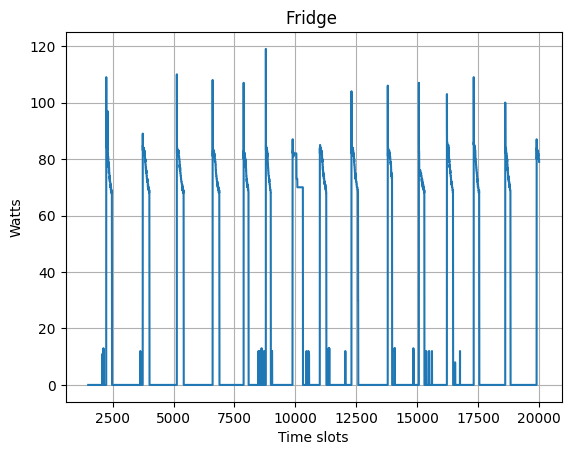

In [ ]:
import matplotlib.pyplot as plt

# Plot all the values in 'Column1'
dataframe['Appliance1'][1500:20000].plot()

# Add labels and title
plt.xlabel('Time slots')
plt.ylabel('Watts')
plt.title('Fridge ')
plt.grid("True")

# Show the plot
plt.show()

# Store the average consumptions of each appliance in the house.

In [7]:
def calculate_avg_appliance_consumption(appliance):

  # Find the maximum and minimum non-zero values
  max_non_zero = dataframe[appliance][dataframe[appliance] != 0].max()
  min_non_zero = dataframe[appliance][dataframe[appliance] != 0].min()

  # Filter the DataFrame to include only values between the maximum and minimum
  filtered_values = dataframe[(dataframe[appliance] > min_non_zero) & (dataframe[appliance] < max_non_zero)][appliance]

  # Calculate the average of the filtered values
  average_between_non_zero = filtered_values.mean()

  return average_between_non_zero

In [8]:
# Save the average consumption of any device in a list.
avg_appliances_consumptions = []

for i in range(1, len(appliances_dict)+1):
  avg_appliances_consumptions.append((appliances_dict["Appliance"+str(i)],calculate_avg_appliance_consumption("Appliance"+str(i))))

print(avg_appliances_consumptions)

[('Fridge', 75.79845793092484), ('Chest Freezer', 48.08923243274837), ('Upright Freezer', 72.21469605959662), ('Tumble Dryer', 472.6271729522687), ('Washing Machine', 513.3838271002094), ('Dishwasher', 1379.0888017181703), ('Computer Site', 29.738480373322528), ('Television Site', 31.700847769012388), ('Electric Heater', 1007.2853867493128)]


# Sostituisco ora tutti i valori in watts presenti con ON e OFF.

In [9]:
discretized_dataframe = dataframe
for i in range(1,len(appliances_dict)+1):
  discretized_dataframe["Appliance"+str(i)] = np.where(dataframe["Appliance"+str(i)] != 0, 'ON', 'OFF')

In [10]:
print(discretized_dataframe)

                        Time        Unix  Aggregate Appliance1 Appliance2  \
0        2013-10-09 13:06:17  1381323977        523         ON        OFF   
1        2013-10-09 13:06:31  1381323991        526         ON        OFF   
2        2013-10-09 13:06:46  1381324006        540         ON        OFF   
3        2013-10-09 13:07:01  1381324021        532         ON        OFF   
4        2013-10-09 13:07:15  1381324035        540         ON        OFF   
...                      ...         ...        ...        ...        ...   
6960003  2015-07-10 11:56:05  1436529365        187        OFF         ON   
6960004  2015-07-10 11:56:12  1436529372        185        OFF         ON   
6960005  2015-07-10 11:56:18  1436529378        181        OFF         ON   
6960006  2015-07-10 11:56:25  1436529385        186        OFF         ON   
6960007  2015-07-10 11:56:32  1436529392        182        OFF         ON   

        Appliance3 Appliance4 Appliance5 Appliance6 Appliance7 Appliance8  

# La cella seguente contiene la funzione che riceve in input il giorno e l'appliance e in output restituisce tutti gli intervalli di funzionamento, ovvero orari (inizio e fine) di ON.

In [11]:
def get_daily_appliance_operating_times(df,day,appliance):
  df['timestamp'] = pd.to_datetime(df['Time'])
  day_to_filter = day

  # Filter rows related to the specific day
  filtered_df = df[df['timestamp'].dt.date == pd.to_datetime(day_to_filter).date()]
  filtered_df.reset_index(drop=True, inplace=True)

  if filtered_df.empty:
    return "The day you have selected is not in the dataset."

  # Initialize lists to store indices of status changes
  on_to_off_indices = []
  off_to_on_indices = []

  # Iterate over the DataFrame
  for i in range(1, len(filtered_df)):
      if filtered_df[appliance][i - 1] == 'ON' and filtered_df[appliance][i] == 'OFF':
          on_to_off_indices.append(i)
      elif filtered_df[appliance][i - 1] == 'OFF' and filtered_df[appliance][i] == 'ON':
          off_to_on_indices.append(i)

  #print("Indices where status changes from ON to OFF:", on_to_off_indices)
  #print("Indices where status changes from OFF to ON:", off_to_on_indices)

  prompt = "During the day: " +day+", the "+appliances_dict[appliance]+" has been ON at these times:\n"

  # Now manage the case of the appliance either ON or OFF all day long.
  if (filtered_df[appliance] == 'ON').all():
    # Case of an appliance always ON during the current day.
    prompt += "From: 00:00:00 To: 23:59:59\n"
    return prompt
  if (filtered_df[appliance] == 'OFF').all():
    # Case of an appliance always OFF during the current day.
    prompt = "During the day: " +day+", the "+appliances_dict[appliance]+" has never been ON.\n"
    return prompt

  # Now manage the case of only one OFF-to-ON or ON-to-OFF switch. (The cases of always ON or OFF has already produced a return with previous lines.)
  if not on_to_off_indices:
    # Case of an appliance that had only one OFF-ON switch during the current day.
    prompt += "From: "+ datetime.strptime(filtered_df.loc[on_to_off_indices[0],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " To: 23:59:59\n"
    return prompt
  if not off_to_on_indices:
    # Case of an appliance that had only one ON-OFF switch during the current day.
    prompt += "From: 00:00:00 To:"+ datetime.strptime(filtered_df.loc[on_to_off_indices[0],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + "\n"
    return prompt


  # In this case at 00:00 the appliance is already ON.
  if on_to_off_indices[0]>off_to_on_indices[0]:
    # The first off index it is useless, and we can remove it to couple the first ON index with the related OFF index of the two lists.
    off_to_on_indices = off_to_on_indices[1:]

  for i in range(0,len(on_to_off_indices)):
    try:
      prompt += "From: "+ datetime.strptime(filtered_df.loc[on_to_off_indices[i],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " To: "+ datetime.strptime(filtered_df.loc[off_to_on_indices[i],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + "\n"
    except:
      prompt += "From: "+ datetime.strptime(filtered_df.loc[on_to_off_indices[i],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " To: 23:59:59\n"

  return prompt

In [12]:
print(get_daily_appliance_operating_times(discretized_dataframe,'2014-01-13','Appliance1'))

During the day: 2014-01-13, the Fridge has been ON at these times:
From: 00:47:17 To: 02:49:00
From: 03:12:46 To: 05:18:29
From: 05:42:00 To: 07:01:02
From: 07:01:29 To: 07:02:15
From: 07:02:29 To: 07:06:00
From: 07:07:01 To: 07:12:31
From: 07:13:48 To: 07:17:19
From: 07:41:45 To: 09:44:48
From: 10:09:00 To: 12:11:30
From: 12:35:48 To: 14:38:33
From: 15:02:48 To: 17:08:47
From: 17:32:45 To: 19:38:19
From: 20:02:47 To: 21:06:48
From: 21:07:07 To: 21:51:29
From: 22:16:04 To: 23:59:59



# Prompt Q1 Experiments.
Non funziona granché. Meglio dare a Mistral solo gli orari e fare i calcoli economici solo io. Eliminare i prezzi anche dal prompt. Dire solo fascia più cara e fascia meno cara. Poi con un parser calcolo il costo per fascia e il costo totale. (v. PROMPT in basso in cui chiedo di evitare spiegazioni).

In [29]:
prompt = """
The hourly rates for electricity are as follows:

F1 (Most expensive) -> From 08:00:00 to 19:00:00, Monday to Friday. Cost: €0.07138 per kWh.
F23 (Less expensive) -> From 19:00:00 to 08:00:00, Monday to Friday. And all day Saturday and Sunday. Cost: €0.06999 per kWh.

The Fridge consumes 150 watts.

During the day: 2013-10-12, the Fridge has been ON at these times:
From: 01:03:30 To: 03:03:30 -> COST: 0.3kwh x 0.06999 € = 0.020997€
From: 03:49:00 To: 06:49:00 -> COST: 0.9kwh x 0.06999 € = 0.062991€
From: 06:00:00 To: 09:00:00 -> COST: (0.3kwh x 0.06999 €) + (0.15kwh x 0.07138 €)= 0.020997€ + 0.010707€ = 0.031704€

TOTAL COST: 0.115692€
Propose a new scheduling, based only on shifting intervals, to reduce electricity cost. Compute the total cost of the new scheduling.
"""

In [31]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2192.47 ms
llama_print_timings:      sample time =     288.11 ms /   433 runs   (    0.67 ms per token,  1502.91 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   54688.92 ms /   433 runs   (  126.30 ms per token,     7.92 tokens per second)
llama_print_timings:       total time =   57253.93 ms /   434 tokens


one possible solution could be turning off the fridge from midnight to 1:03am and then turn it back on at 3:03am (instead of leaving it on all night). this way, the consumption would fall under f23 tariff instead of f1 tariff.

new scheduling:
from: off from 00:00:00 to: 01:03:30 -> cost: 0kwh x 0.06999 € = 0€
from: on from 03:03:30 to: 06:49:00 -> cost: 0.75kwh x 0.06999 € = 0.052493€
from: off from 06:49:00 to: 08:00:00, monday to friday -> cost: (0.1kwh x 0.07138 €) + (0.15kwh x 0.06999 €)= 0.007138€ + 0.010699€ = 0.017837€
from: on from 19:00:00 to: 24:00:00, saturday and sunday -> cost: (0.5kwh x 0.06999 €) + (0.5kwh x 0.06999 €) = 0.03338€
total cost of new scheduling: 0.052493€ + 0.017837€ + 0.03338€ = 0.10362€

this new scheduling results in a total cost reduction of approximately €0.012172€ compared to the original scheduling.


In [22]:
prompt = """
<s>
The hourly rates for electricity are as follows:

F1 -> From 08:00 to 19:00, Monday to Friday. Cost: €0.07138 per kWh.
F23 -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday. Cost: €0.06999 per kWh.
The appliance consumes 150 watts.

[INST]
During the day: 2013-10-12, the Fridge has been ON at these times:
From: 01:03:30 To: 03:21:45
From: 03:49:00 To: 06:09:12
From: 06:36:27 To: 08:58:13
From: 09:29:35 To: 11:46:30
From: 12:13:58 To: 14:34:59
From: 15:01:50 To: 17:22:45
From: 17:49:58 To: 20:11:44
From: 20:38:44 To: 23:01:44
From: 23:28:58 To: 23:59:59

Propose a new, based only on shifting intervals, scheduling to reduce electricity cost. Compute the total cost. AVOID EXPLANATIONS.

ANSWER: [/INST]

From: 01:03:30 To: 03:21:45
From: 03:49:00 To: 06:09:12
From: 06:06:27 To: 08:28:13
From: 09:29:35 To: 11:46:30
From: 12:13:58 To: 14:34:59
From: 15:01:50 To: 17:22:45
From: 18:19:58 To: 20:41:44
From: 20:58:44 To: 23:21:44
From: 23:38:58 To: 23:59:59

</s>

<INST>
During the day: 2014-01-13, the Fridge has been ON at these times:
From: 00:47:17 To: 02:49:00
From: 03:12:46 To: 05:18:29
From: 05:42:00 To: 07:01:02
From: 07:01:29 To: 07:02:15
From: 07:02:29 To: 07:06:00
From: 07:07:01 To: 07:12:31
From: 07:13:48 To: 07:17:19
From: 07:41:45 To: 09:44:48
From: 10:09:00 To: 12:11:30
From: 12:35:48 To: 14:38:33
From: 15:02:48 To: 17:08:47
From: 17:32:45 To: 19:38:19
From: 20:02:47 To: 21:06:48
From: 21:07:07 To: 21:51:29
From: 22:16:04 To: 23:59:59

Propose a new scheduling, based only on shifting intervals, to reduce electricity cost. Compute the total cost. AVOID EXPLANATIONS.

ANSWER: [/INST]

"""

In [25]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2192.47 ms
llama_print_timings:      sample time =     321.29 ms /   510 runs   (    0.63 ms per token,  1587.38 tokens per second)
llama_print_timings: prompt eval time =     601.47 ms /   370 tokens (    1.63 ms per token,   615.16 tokens per second)
llama_print_timings:        eval time =   64565.51 ms /   509 runs   (  126.85 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   71189.64 ms /   879 tokens


to optimize the electricity consumption and reduce costs, we propose the following schedule for the fridge:

1. use f1 (daytime rate) as much as possible during weekdays from 08:00 to 19:00. this reduces the usage of f23 which is more expensive.

2. based on the given data, we observe that the fridge is mostly used between 06:00 and 20:00. therefore, instead of keeping it on throughout these hours, we can schedule it to turn on at optimal times when the f1 rate is applicable.

proposed schedule:
from: 06:30 to: 08:54 (start 1 hour earlier and end 2 minutes before 9 am)
from: 13:00 to: 15:30 (shift the midday usage by 1.5 hours)
from: 17:00 to: 19:30 (shift the evening usage by 1 hour)

total energy consumption in each period will remain the same, and the total cost can be computed as follows:

cost = (energy consumption in period 1 * rate f1) + (energy consumption in periods 2-8 * rate f23)

first, calculate the energy consumption for each period from the given data. then use the propo

In [19]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2192.47 ms
llama_print_timings:      sample time =     192.88 ms /   299 runs   (    0.65 ms per token,  1550.21 tokens per second)
llama_print_timings: prompt eval time =    1024.67 ms /   663 tokens (    1.55 ms per token,   647.04 tokens per second)
llama_print_timings:        eval time =   38493.25 ms /   298 runs   (  129.17 ms per token,     7.74 tokens per second)
llama_print_timings:       total time =   48279.29 ms /   961 tokens


from: 01:12:46 to: 03:18:29
from: 03:45:00 to: 05:40:02
from: 05:47:15 to: 06:01:15
from: 06:12:31 to: 06:18:31
from: 06:43:45 to: 09:40:48
from: 10:11:30 to: 12:11:30
from: 12:31:48 to: 14:35:33
from: 15:08:47 to: 17:08:47
from: 17:32:45 to: 19:30:19
from: 20:06:48 to: 21:00:48
from: 21:07:07 to: 21:51:29
from: 22:16:04 to: 23:00:09
from: 23:02:12 to: 23:59:59


## Funzione per il preprocessing dei few shots.

In [ ]:
old_question = "QUESTION: How many packets are received for each device?"
new_question = "QUESTION: How many frames are received for each DEVICE?"

def preprocess_sample(file_contents,n):
                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()
                else:
                  return "Target sentence not found in the input string."

                sample ="<s>[INST]\n"
                modified_string = file_contents.replace(old_question, new_question)
                modified_string = modified_string.replace("ANSWER:", "ANSWER: [/INST]")

                sample += modified_string
                sample += "</s>\n\n"

                return sample


## Create few-shot samples from the folder.

In [ ]:
def create_few_shots_set(folder_path,nr_samples):
    # Initialize an empty string to store the concatenated contents
    few_shots_set = """
CONTEXT:
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
"""
    #few_shots_set=""

    # Counter to keep track of the number of files read
    count = 0

    # Iterate through all files in the folder
    for filename in files:
        print(filename)
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                few_shots_set+=preprocess_sample(file_contents,count)

                # Increment the counter
                count += 1

                # Check if reached the limit of n files
                if count == n:
                    break

    return few_shots_set

In [ ]:
# Specify the path to the folder containing the text files
folder_path = "prompt_Q1"

# Specify the number of files to read
n = 3  # Example: Read the first 5 files

# Call the function to read text files in the folder and concatenate their contents
few_shots_samples = create_few_shots_set(folder_path, n)

# Print or use the concatenated contents as needed
print(few_shots_samples)

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt

CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
<s>[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:

## Esperimento 1 del 02/04/2024.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()

                prompt = few_shots_samples + "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = file_contents.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt

CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
<s>[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -11


llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      88.52 ms /   158 runs   (    0.56 ms per token,  1784.95 tokens per second)
llama_print_timings: prompt eval time =    6304.40 ms /  3809 tokens (    1.66 ms per token,   604.18 tokens per second)
llama_print_timings:        eval time =   18581.37 ms /   157 runs   (  118.35 ms per token,     8.45 tokens per second)
llama_print_timings:       total time =   38773.31 ms /  3966 tokens


to find out how many packets are received for each device, we need to identify each device based on its unique extended unique identifier (dev\_eui). by looking through the given data, we can see that all packets belong to two different devices, dev\_eui: 120 and dev\_eui: 124.

device dev\_eui:120 has received a total of 11 packets.

device dev\_eui:124 has received a total of 12 packets.

so, the answer would be: device dev\_eui:120 has received 11 packets, and device dev\_eui:124 has received 12 packets.


## Esperimento 2 del 02/04/2024. Scrivo bene la domanda sul sample di test.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()

                old_question = "QUESTION: How many packets are received for each device?"
                new_question = "QUESTION: Given the previous lines, how many packets are received for each device?"
                modified_string = file_contents.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt

CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
<s>[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -11

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      89.55 ms /   153 runs   (    0.59 ms per token,  1708.54 tokens per second)
llama_print_timings: prompt eval time =     738.55 ms /    26 tokens (   28.41 ms per token,    35.20 tokens per second)
llama_print_timings:        eval time =   18391.15 ms /   152 runs   (  120.99 ms per token,     8.26 tokens per second)
llama_print_timings:       total time =   20002.76 ms /   178 tokens


for device dev_eui:120 all received frames are 5.
for device dev_eui:121 all received frames are 3.
for device dev_eui:122 all received frames are 11.
for device dev_eui:123 all received frames are 3.
for device dev_eui:124 all received frames are 9.
for device dev_eui:126 all received frames are 3.
for device dev_eui:127 all received frames are 4.
for device dev_eui:128 all received frames are 3.


## Esperimento 3 del 02/04/2024. Adesso provo a spostare il tag di apertura \<s> prima di CONTEXT.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
<s>
CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -11

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      78.48 ms /   134 runs   (    0.59 ms per token,  1707.42 tokens per second)
llama_print_timings: prompt eval time =    6089.17 ms /  3812 tokens (    1.60 ms per token,   626.03 tokens per second)
llama_print_timings:        eval time =   15815.84 ms /   133 runs   (  118.92 ms per token,     8.41 tokens per second)
llama_print_timings:       total time =   34261.22 ms /  3945 tokens


for device dev\_eui:120 all received frames are 2.
for device dev\_eui:121 all received frames are 3.
for device dev\_eui:123 all received frames are 2.
for device dev\_eui:124 all received frames are 10.
for device dev\_eui:126 all received frames are 3.
for device dev\_eui:127 all received frames are 3.
for device dev\_eui:128 all received frames are 3.


## Esperimento 4 del 02/04/2024. Cambio la domanda (v.output).

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
<s>
CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -11

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      92.63 ms /   153 runs   (    0.61 ms per token,  1651.80 tokens per second)
llama_print_timings: prompt eval time =    3498.09 ms /  2077 tokens (    1.68 ms per token,   593.75 tokens per second)
llama_print_timings:        eval time =   18352.83 ms /   152 runs   (  120.74 ms per token,     8.28 tokens per second)
llama_print_timings:       total time =   28705.95 ms /  2229 tokens


for device dev\_eui:120 all received frames are 3.
for device dev\_eui:121 all received frames are 2.
for device dev\_eui:122 all received frames are 7.
for device dev\_eui:123 all received frames are 2.
for device dev\_eui:124 all received frames are 11.
for device dev\_eui:126 all received frames are 2.
for device dev\_eui:127 all received frames are 4.
for device dev\_eui:128 all received frames are 3.


## Esperimento 5. Modifico di nuovo la domanda (v. output) ZERO SHOT.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt

[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563  868.3    1    22   0.0 -114.0  SF7  125  4/5      123  7276FF002E0616BF    23  3914
6  2019-05-20 00:40:34.091  868.3    1    22   5.0 -110.0  SF7  125  4/5      121  7276FF002E0616BF    25  4093
7  2019-05-20 00:47:19.146  868.1    1    21  13.0  -99.0  SF7  125  4/5      127 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      55.43 ms /    99 runs   (    0.56 ms per token,  1786.20 tokens per second)
llama_print_timings: prompt eval time =    2986.98 ms /  1623 tokens (    1.84 ms per token,   543.36 tokens per second)
llama_print_timings:        eval time =   11339.86 ms /    98 runs   (  115.71 ms per token,     8.64 tokens per second)
llama_print_timings:       total time =   23743.82 ms /  1721 tokens


to determine the number of packets received for each device based on the given data, we can simply count the number of rows in the dataset that have the same `dev_eui` value.

in this case, all rows have the same `dev_eui` value, so there is only one device with the given unique identifier. therefore, the number of packets received for this device is equal to the total number of rows in the dataset, which is 17.


## Esperimento 6. Altro Zero Shot.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace("ns_time", "row             ns_time")

                modified_string = modified_string.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt

[INST]
row   ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563  868.3    1    22   0.0 -114.0  SF7  125  4/5      123  7276FF002E0616BF    23  3914
6  2019-05-20 00:40:34.091  868.3    1    22   5.0 -110.0  SF7  125  4/5      121  7276FF002E0616BF    25  4093
7  2019-05-20 00:47:19.146  868.1    1    21  13.0  -99.0  SF7  125  4/5    

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      52.56 ms /    99 runs   (    0.53 ms per token,  1883.63 tokens per second)
llama_print_timings: prompt eval time =    2848.11 ms /  1619 tokens (    1.76 ms per token,   568.45 tokens per second)
llama_print_timings:        eval time =   11395.16 ms /    98 runs   (  116.28 ms per token,     8.60 tokens per second)
llama_print_timings:       total time =   21496.63 ms /  1717 tokens


to find the number of packets received for each device, you need to count the number of rows in the table where the "dev\_eui" column matches for each device. in this case, all rows have the same "dev\_eui" value, so the number of packets received for this device is the total number of rows in the table. the total number of rows is 17. therefore, the answer is that 17 packets are received for this device.


In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace("ns_time", "row               ns_time")

                modified_string = modified_string.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt

[INST]
row               ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563  868.3    1    22   0.0 -114.0  SF7  125  4/5      123  7276FF002E0616BF    23  3914
6  2019-05-20 00:40:34.091  868.3    1    22   5.0 -110.0  SF7  125  4/5      121  7276FF002E0616BF    25  4093
7  2019-05-20 00:47:19.146  868.1    1    21  13.0  -99.0  SF7  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =     112.55 ms /   203 runs   (    0.55 ms per token,  1803.64 tokens per second)
llama_print_timings: prompt eval time =    2957.49 ms /  1618 tokens (    1.83 ms per token,   547.09 tokens per second)
llama_print_timings:        eval time =   24190.95 ms /   202 runs   (  119.76 ms per token,     8.35 tokens per second)
llama_print_timings:       total time =   36861.97 ms /  1820 tokens


to find the number of packets received for each device, we need to count the number of rows in the table where the "dev\_eui" column matches for each device. based on the given data, the number of packets received for each device are as follows:

- device with dev\_eui = 7276ff002e0616bf: 13 packets

you can also write a code to count the rows for each device if you are working with this data programmatically:

```python
import pandas as pd

# assuming the data is in a dataframe called 'data'
device_counts = data['dev_eui'].value_counts()
print(device_counts)
```

this will output the count of occurrences for each unique value in the 'dev\_eui' column, which represents the number of packets received for each device.


## Esperimento 7. Ancora una volta c'è stato un errore nella domanda. Mistral pensa che i pacchetti ricevuti siano quelli del gateway. Cambiamo domanda.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace("ns_time", "row               ns_time")

                modified_string = modified_string.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt

[INST]
row               ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563  868.3    1    22   0.0 -114.0  SF7  125  4/5      123  7276FF002E0616BF    23  3914
6  2019-05-20 00:40:34.091  868.3    1    22   5.0 -110.0  SF7  125  4/5      121  7276FF002E0616BF    25  4093
7  2019-05-20 00:47:19.146  868.1    1    21  13.0  -99.0  SF7  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      70.40 ms /   126 runs   (    0.56 ms per token,  1789.70 tokens per second)
llama_print_timings: prompt eval time =     626.61 ms /    23 tokens (   27.24 ms per token,    36.71 tokens per second)
llama_print_timings:        eval time =   14548.72 ms /   125 runs   (  116.39 ms per token,     8.59 tokens per second)
llama_print_timings:       total time =   15801.77 ms /   148 tokens


to determine the number of packets transmitted by each device, we need to count the number of rows in the dataset where the `dev_eui` column matches for each device.

in this dataset, the `dev_eui` column is constant for all rows, so each device has the same `dev_eui` value throughout. therefore, the number of rows for each device is equal to the total number of rows in the dataset.

so, the number of packets transmitted by each device is the same as the total number of rows in the dataset, which is 17.


## Esperimento 8. Zero shot non funziona. Devo fare capire a Mistral cosa mi aspetto. Torniamo a 1-Shot e nuova domanda.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = modified_string.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                ##prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
<s>
CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -11

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =     141.87 ms /   249 runs   (    0.57 ms per token,  1755.09 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   29694.62 ms /   249 runs   (  119.26 ms per token,     8.39 tokens per second)
llama_print_timings:       total time =   30927.40 ms /   250 tokens


based on the given data, each device seems to transmit multiple packets with different frame counters (fcnt) values, indicating distinct messages being sent. therefore, to determine the number of packets transmitted by each device, we need to identify unique combinations of "dev\_eui" and "fcnt" values. here's the count for each device:

* device dev\_eui:120 - 10 packets
* device dev\_eui:121 - 8 packets
* device dev\_eui:123 - 3 packets
* device dev\_eui:124 - 13 packets
* device dev\_eui:126 - 3 packets
* device dev\_eui:127 - 3 packets
* device dev\_eui:128 - 3 packets

please note that this analysis assumes each unique combination of "dev\_eui" and "fcnt" represents a distinct packet transmission. if there are any duplicate rows within the data for a given "dev\_eui," then the packet count may be underestimated for that device.


## Esperimento 9. Provo con altra domanda. (v. output)

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                ##prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
<s>
CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -11

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      93.48 ms /   153 runs   (    0.61 ms per token,  1636.77 tokens per second)
llama_print_timings: prompt eval time =    3372.22 ms /  1906 tokens (    1.77 ms per token,   565.21 tokens per second)
llama_print_timings:        eval time =   17933.31 ms /   152 runs   (  117.98 ms per token,     8.48 tokens per second)
llama_print_timings:       total time =   27202.93 ms /  2058 tokens


for device dev\_eui:120 all received frames are 3.
for device dev\_eui:121 all received frames are 3.
for device dev\_eui:122 all received frames are 7.
for device dev\_eui:123 all received frames are 2.
for device dev\_eui:124 all received frames are 11.
for device dev\_eui:126 all received frames are 3.
for device dev\_eui:127 all received frames are 6.
for device dev\_eui:128 all received frames are 3.


## Esperimento 10. Rimuovo il CONTEXT iniziale.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace(old_question, new_question)

                prompt = few_shots_samples + "\n[INST]\n"

                ##prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
<s>
[INST]
ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563  868.3    1    22   0.0 -114.0  SF7  125  4/5      123  7276FF002E0616BF    23  3914
6  2019-05-20 00:40:34.091  868.3    1    22   5.0 -110.0  SF7  125  4/5      121  7276FF002E0616BF    25  4093
7  2019-05-20 00:47:19.146  868.1    1    21 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      87.85 ms /   152 runs   (    0.58 ms per token,  1730.14 tokens per second)
llama_print_timings: prompt eval time =    5795.66 ms /  3696 tokens (    1.57 ms per token,   637.72 tokens per second)
llama_print_timings:        eval time =   17991.90 ms /   151 runs   (  119.15 ms per token,     8.39 tokens per second)
llama_print_timings:       total time =   35558.65 ms /  3847 tokens


for device dev\_eui:120 all received frames are 3.
for device dev\_eui:121 all received frames are 3.
for device dev\_eui:122 all received frames are 7.
for device dev\_eui:123 all received frames are 3.
for device dev\_eui:124 all received frames are 8.
for device dev\_eui:126 all received frames are 3.
for device dev\_eui:127 all received frames are 4.
for device dev\_eui:128 all received frames are 3.


## Esperimento 11. Cambio domanda (frames non pacchetti). E ho anche rimosso la colonna con il numero di antenna. E vado in 3Shots. Ora funziona meglio.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace(old_question, new_question)

                modified_string = modified_string.replace("ant", "")
                modified_string = modified_string.replace(" 1 ", "")

                few_shots_samples = few_shots_samples.replace("ant", "")
                few_shots_samples = few_shots_samples.replace(" 1 ", "")

                prompt = few_shots_samples + "\n[INST]\n"

                ##prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
prompt_n_hours=2_skip_days=14.txt

CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
-  is the gateway enna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
<s>[INST]
ns_time   freq    chan  lsnr      SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1      21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5      23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5      23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =     155.62 ms /   285 runs   (    0.55 ms per token,  1831.35 tokens per second)
llama_print_timings: prompt eval time =   13578.80 ms /  7383 tokens (    1.84 ms per token,   543.72 tokens per second)
llama_print_timings:        eval time =   34638.67 ms /   284 runs   (  121.97 ms per token,     8.20 tokens per second)
llama_print_timings:       total time =   71500.05 ms /  7667 tokens


for device dev_eui:120 all received frames are 3.
for device dev_eui:121 all received frames are 1.
for device dev_eui:122 all received frames are 3.
for device dev_eui:123 all received frames are 6.
for device dev_eui:124 all received frames are 3.
for device dev_eui:126 all received frames are 2.
for device dev_eui:127 all received frames are 2.
for device dev_eui:128 all received frames are 2.

therefore, the total number of frames received for each device are as follows:

device dev_eui:120 - 3 frames
device dev_eui:121 - 1 frame
device dev_eui:122 - 3 frames
device dev_eui:123 - 6 frames
device dev_eui:124 - 3 frames
device dev_eui:126 - 2 frames
device dev_eui:127 - 2 frames
device dev_eui:128 - 2 frames


## Ora rimuovo pure il canale. Esperimento fallito.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()


                modified_string = file_contents.replace(old_question, new_question)

                modified_string = modified_string.replace("ant", "")
                modified_string = modified_string.replace(" 1 ", "")

                few_shots_samples = few_shots_samples.replace("ant", "")
                few_shots_samples = few_shots_samples.replace(" 1 ", "")

                modified_string = modified_string.replace("chan", "")
                modified_string = modified_string.replace(" 21 ", "")
                modified_string = modified_string.replace(" 22 ", "")
                modified_string = modified_string.replace(" 23 ", "")

                few_shots_samples = few_shots_samples.replace("chan", "")
                few_shots_samples = few_shots_samples.replace(" 21 ", "")
                few_shots_samples = few_shots_samples.replace(" 22 ", "")
                few_shots_samples = few_shots_samples.replace(" 23 ", "")

                prompt = few_shots_samples + "\n[INST]\n"

                ##prompt = "\n[INST]\n"

                # Split the string at the occurrence of "ANSWER:"
                parts = modified_string.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
prompt_n_hours=2_skip_days=14.txt

CONTEXT: 
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
-  is the gateway enna identifier
- n is the nel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
<s>[INST]
ns_time   freq      lsnr      SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1      -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    3843
1  2019-05-20 00:17:25.006  868.5       6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    4086
2  2019-05-20 00:19:16.051  868.5      -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    4098
3  2019-05-20 00:26:39.495  868.5      -9.0 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1332.03 ms
llama_print_timings:      sample time =      74.58 ms /   132 runs   (    0.56 ms per token,  1770.01 tokens per second)
llama_print_timings: prompt eval time =   12751.18 ms /  6952 tokens (    1.83 ms per token,   545.20 tokens per second)
llama_print_timings:        eval time =   16127.42 ms /   131 runs   (  123.11 ms per token,     8.12 tokens per second)
llama_print_timings:       total time =   52198.44 ms /  7083 tokens


for device dev\_eui:122, a total of 6 frames were received.
for device dev\_eui:123, a total of 8 frames were received.
for device dev\_eui:124, a total of 4 frames were received.
for device dev\_eui:126, a total of 1 frame was received.
for device dev\_eui:127, a total of 5 frames were received.
for device dev\_eui:128, a total of 2 frames were received.


## Con 4 samples few-shot c'è un eccesso di dimensione token per la finestra di contesto. Devo usarne 3. Mistral ha una finestra di contesto di 8192. Provato a usare il CONTEXT specificato da Fabrizio... Risultati errati. Ora viene rimosso quel paragrafo sia dai few-shot sia dall'esperimento test.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()

                prompt = few_shots_samples + """\n[INST]\n

                --------------------------------------------------------------------------
                SHOT """+str(test_sample_index)+"""
                --------------------------------------------------------------------------

                """
                # Split the string at the occurrence of "ANSWER:"
                parts = file_contents.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
prompt_n_hours=2_skip_days=14.txt
<s>
[INST]


                --------------------------------------------------------------------------
                SHOT 0
                --------------------------------------------------------------------------

                CONTEXT: Following lines shows a LoRa log for 2 hours selection in tabular format where:
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
                   ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt


Llama.generate: prefix-match hit

llama_print_timings:        load time =    1194.48 ms
llama_print_timings:      sample time =     131.97 ms /   168 runs   (    0.79 ms per token,  1273.01 tokens per second)
llama_print_timings: prompt eval time =   15080.29 ms /  8006 tokens (    1.88 ms per token,   530.89 tokens per second)
llama_print_timings:        eval time =   20858.97 ms /   167 runs   (  124.90 ms per token,     8.01 tokens per second)
llama_print_timings:       total time =   73941.35 ms /  8173 tokens


for device dev\_eui: 120, all received frames are 3.
for device dev\_eui: 121, all received frames are 1.
for device dev\_eui: 122, all received frames are 5.
for device dev\_eui: 123, all received frames are 6.
for device dev\_eui: 124, all received frames are 4.
for device dev\_eui: 126, all received frames are 3.
for device dev\_eui: 127, all received frames are 3.
for device dev\_eui: 128, all received frames are 2.


Ora provo includendo il CONTEXT dato da Fabri. Solo per il primo sample.

Purtroppo Llama (4092) e tutti i derivati sono pre-trainati su codici con queste finestre e questo comporta che non solo non sono efficienti con finestre più grandi di contesto ma sopratutto non le possono ricevere come input...Devo inventarmi qualcosa per fargli capire i file di log riducendo l'informazione disponibile che gli do in pasto.

## Provo a inserire il formato precedente che riporta i numeri degli shot. Il CONTEXT viene dato solo una volta all'inizio.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()

                prompt = few_shots_samples + """\n[INST]\n

                --------------------------------------------------------------------------
                SHOT """+str(test_sample_index)+"""
                --------------------------------------------------------------------------

                """
                # Split the string at the occurrence of "ANSWER:"
                parts = file_contents.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
prompt_n_hours=2_skip_days=14.txt
<s>

                
                CONTEXT: Following lines shows a LoRa log for 2 hours selection in tabular format where:
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter </s><s>

                
                
                [INST]


                --------------------------------------------------------------------------
                SHOT 0
                --------------------------------------------------------------------------

                ns_time   freq  ant


llama_print_timings:        load time =    1055.95 ms
llama_print_timings:      sample time =      85.88 ms /   152 runs   (    0.57 ms per token,  1769.83 tokens per second)
llama_print_timings: prompt eval time =   13571.17 ms /  7736 tokens (    1.75 ms per token,   570.03 tokens per second)
llama_print_timings:        eval time =   15588.72 ms /   151 runs   (  103.24 ms per token,     9.69 tokens per second)
llama_print_timings:       total time =   62844.39 ms /  7887 tokens


for device dev\_eui:120 all received frames are 3.
for device dev\_eui:121 all received frames are 2.
for device dev\_eui:122 all received frames are 7.
for device dev\_eui:123 all received frames are 5.
for device dev\_eui:124 all received frames are 4.
for device dev\_eui:126 all received frames are 3.
for device dev\_eui:127 all received frames are 3.
for device dev\_eui:128 all received frames are 3.


## Prompt #1 (Vecchia domanda)

In [ ]:
prompt = """<s>
[INST]
--------------------------------------------------------------------------
SHOT 1
--------------------------------------------------------------------------
LOG:
[TX] timestamp:0.6468 X:-121.766 Y:507.761 Z:1.2 SF:7 FCnt:1 DevID:201
[RX] timestamp:0.713617 SF:7 FCnt:1 DevID:201 GwID:1000 RSSI:-18.008
[TX] timestamp:0.827825 X:781.281 Y:542.276 Z:1.2 SF:7 FCnt:1 DevID:194
[RX] timestamp:0.894644 SF:7 FCnt:1 DevID:194 GwID:1000 RSSI:-23.8409
[TX] timestamp:1.06166 X:-333.009 Y:791.847 Z:1.2 SF:8 FCnt:1 DevID:313
[RX] timestamp:1.17482 SF:8 FCnt:1 DevID:313 GwID:1000 RSSI:-25.5281
[TX] timestamp:1.38418 X:-422.336 Y:-40.1951 Z:1.2 SF:8 FCnt:1 DevID:275
[TX] timestamp:1.44612 X:-26.2489 Y:291.458 Z:1.2 SF:9 FCnt:1 DevID:324
[RX] timestamp:1.49734 SF:8 FCnt:1 DevID:275 GwID:1000 RSSI:-15.5825
[TX] timestamp:1.63083 X:-657.862 Y:-257.213 Z:1.2 SF:9 FCnt:1 DevID:459

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:1 DevID:201
FCnt:1 DevID:194
FCnt:1 DevID:313
FCnt:1 DevID:275

[INST]
--------------------------------------------------------------------------
SHOT 2
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2648.73 X:-440.021 Y:869.082 Z:1.2 SF:9 FCnt:18 DevID:397
[TX] timestamp:2648.81 X:311.122 Y:52.3937 Z:1.2 SF:9 FCnt:19 DevID:354
[TX] timestamp:2649.04 X:-666.532 Y:409.071 Z:1.2 SF:7 FCnt:18 DevID:127
[RX] timestamp:2649.11 SF:7 FCnt:18 DevID:127 GwID:1000 RSSI:-22.4458
[TX] timestamp:2649.28 X:-686.965 Y:424.943 Z:1.2 SF:10 FCnt:18 DevID:556
[TX] timestamp:2649.4 X:-500.989 Y:-281.463 Z:1.2 SF:12 FCnt:18 DevID:953
[TX] timestamp:2649.55 X:482.547 Y:661.83 Z:1.2 SF:9 FCnt:19 DevID:461
[TX] timestamp:2649.68 X:-823.016 Y:236.865 Z:1.2 SF:12 FCnt:19 DevID:938
[RX] timestamp:2649.69 SF:10 FCnt:18 DevID:556 GwID:1000 RSSI:-22.8529
[TX] timestamp:2649.76 X:-132.851 Y:789.532 Z:1.2 SF:7 FCnt:18 DevID:209
[TX] timestamp:2650.12 X:-105.438 Y:-818.834 Z:1.2 SF:12 FCnt:18 DevID:882
[TX] timestamp:2650.27 X:185.458 Y:-191.048 Z:1.2 SF:7 FCnt:20 DevID:173
[TX] timestamp:2650.52 X:419.132 Y:-198.629 Z:1.2 SF:8 FCnt:18 DevID:310
[TX] timestamp:2650.54 X:608.034 Y:200.211 Z:1.2 SF:12 FCnt:18 DevID:991

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:127
FCnt:18 DevID:556

[INST]
--------------------------------------------------------------------------
SHOT 3
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2653.45 X:-234.757 Y:837.144 Z:1.2 SF:12 FCnt:17 DevID:820
[TX] timestamp:2653.63 X:-376.778 Y:-284.276 Z:1.2 SF:10 FCnt:18 DevID:567
[TX] timestamp:2653.72 X:-346.365 Y:573.88 Z:1.2 SF:11 FCnt:19 DevID:694
[TX] timestamp:2654.02 X:-534.374 Y:-815.789 Z:1.2 SF:11 FCnt:19 DevID:713
[TX] timestamp:2654.11 X:621.242 Y:595.208 Z:1.2 SF:12 FCnt:18 DevID:833
[TX] timestamp:2654.34 X:112.828 Y:-538.224 Z:1.2 SF:10 FCnt:19 DevID:501
[TX] timestamp:2654.46 X:592.428 Y:239.434 Z:1.2 SF:11 FCnt:19 DevID:654
[TX] timestamp:2654.74 X:-587.472 Y:533.362 Z:1.2 SF:12 FCnt:18 DevID:949
[TX] timestamp:2654.8 X:252.053 Y:852.557 Z:1.2 SF:7 FCnt:18 DevID:234
[TX] timestamp:2655.14 X:-749.124 Y:-461.172 Z:1.2 SF:7 FCnt:18 DevID:227
[RX] timestamp:2655.21 SF:7 FCnt:18 DevID:227 GwID:1000 RSSI:-28.7341
[TX] timestamp:2655.23 X:371.431 Y:-279.928 Z:1.2 SF:7 FCnt:18 DevID:81
[RX] timestamp:2655.29 SF:7 FCnt:18 DevID:81 GwID:1000 RSSI:-18.1152
[TX] timestamp:2655.56 X:-398.763 Y:712.809 Z:1.2 SF:12 FCnt:19 DevID:976
[TX] timestamp:2655.57 X:230.417 Y:-424.954 Z:1.2 SF:9 FCnt:18 DevID:365
[TX] timestamp:2655.62 X:131.58 Y:712.52 Z:1.2 SF:7 FCnt:18 DevID:206

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:227

[INST]
--------------------------------------------------------------------------
SHOT 4
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2687.2 X:463.389 Y:-236.677 Z:1.2 SF:9 FCnt:18 DevID:426
[TX] timestamp:2687.53 X:66.113 Y:-738.793 Z:1.2 SF:11 FCnt:18 DevID:728
[TX] timestamp:2687.54 X:144.319 Y:-575.014 Z:1.2 SF:11 FCnt:19 DevID:662
[TX] timestamp:2687.59 X:-973.318 Y:53.1513 Z:1.2 SF:7 FCnt:18 DevID:104
[TX] timestamp:2687.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:19 DevID:437
[TX] timestamp:2687.71 X:-450.642 Y:582.25 Z:1.2 SF:9 FCnt:18 DevID:485
[TX] timestamp:2688.21 X:-632.002 Y:62.4065 Z:1.2 SF:9 FCnt:18 DevID:378
[TX] timestamp:2688.22 X:-640.969 Y:-217.14 Z:1.2 SF:9 FCnt:18 DevID:335
[TX] timestamp:2688.3 X:-269.892 Y:387.497 Z:1.2 SF:7 FCnt:18 DevID:132
[RX] timestamp:2688.36 SF:7 FCnt:18 DevID:132 GwID:1000 RSSI:-13.8264
[TX] timestamp:2688.55 X:494.356 Y:-38.1804 Z:1.2 SF:10 FCnt:18 DevID:554
[TX] timestamp:2688.68 X:-66.4033 Y:-308.721 Z:1.2 SF:7 FCnt:18 DevID:101
[TX] timestamp:2688.73 X:-574.57 Y:-45.9266 Z:1.2 SF:7 FCnt:18 DevID:31
[TX] timestamp:2688.82 X:207.679 Y:-570.899 Z:1.2 SF:12 FCnt:18 DevID:948
[TX] timestamp:2688.95 X:202.35 Y:-197.221 Z:1.2 SF:12 FCnt:19 DevID:879

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:132

[INST]
--------------------------------------------------------------------------
SHOT 5
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2836.12 X:-763.089 Y:303.751 Z:1.2 SF:9 FCnt:19 DevID:340
[RX] timestamp:2836.34 SF:9 FCnt:19 DevID:340 GwID:1000 RSSI:-22.1819
[TX] timestamp:2836.36 X:667.276 Y:209.04 Z:1.2 SF:7 FCnt:19 DevID:159
[TX] timestamp:2836.39 X:-36.1486 Y:531.612 Z:1.2 SF:11 FCnt:19 DevID:648
[TX] timestamp:2836.4 X:533.818 Y:710.866 Z:1.2 SF:9 FCnt:19 DevID:338
[RX] timestamp:2836.42 SF:7 FCnt:19 DevID:159 GwID:1000 RSSI:-24.4854
[TX] timestamp:2836.5 X:602.687 Y:-299.853 Z:1.2 SF:9 FCnt:19 DevID:412
[TX] timestamp:2836.64 X:-497.759 Y:424.351 Z:1.2 SF:11 FCnt:20 DevID:682
[RX] timestamp:2836.72 SF:9 FCnt:19 DevID:412 GwID:1000 RSSI:-23.1671
[TX] timestamp:2836.8 X:647.59 Y:-302.591 Z:1.2 SF:8 FCnt:19 DevID:269
[TX] timestamp:2836.84 X:-932.651 Y:-299.507 Z:1.2 SF:10 FCnt:19 DevID:500
[RX] timestamp:2836.91 SF:8 FCnt:19 DevID:269 GwID:1000 RSSI:-20.7882
[TX] timestamp:2837.09 X:463.067 Y:122.925 Z:1.2 SF:11 FCnt:20 DevID:724
[TX] timestamp:2837.17 X:391.675 Y:-283.426 Z:1.2 SF:12 FCnt:20 DevID:831
[TX] timestamp:2837.22 X:-738.937 Y:-485.112 Z:1.2 SF:12 FCnt:19 DevID:950
[TX] timestamp:2837.42 X:746.141 Y:-277.532 Z:1.2 SF:9 FCnt:19 DevID:381
[TX] timestamp:2837.54 X:81.7345 Y:415.861 Z:1.2 SF:7 FCnt:20 DevID:213
[TX] timestamp:2837.72 X:-860.745 Y:-197.434 Z:1.2 SF:9 FCnt:19 DevID:389

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]

</s>
"""

In [ ]:
response = lcpp_llm(
        prompt=prompt,
        max_tokens = None,
        #temperature= 0.9,
        #logprobs=1,
      )

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1489.57 ms
llama_print_timings:      sample time =      76.06 ms /   109 runs   (    0.70 ms per token,  1433.02 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   11868.37 ms /   109 runs   (  108.88 ms per token,     9.18 tokens per second)
llama_print_timings:       total time =   12588.20 ms /   110 tokens


In [ ]:
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

fcnt:19 devid:340, devid:412, devid:269, devid:381, devid:213, devid:389

the answer includes all the devices with a fcnt (frame counter) value of 19 and the correct corresponding device ids (devid) from the given log that have both a successful transmission (rx) and transmission attempt (tx) record with the same fcnt value in the log.


## Prompt #2 (Vecchia domanda)

In [ ]:
prompt = """<s>
[INST]
--------------------------------------------------------------------------
SHOT 1
--------------------------------------------------------------------------
LOG:
[TX] timestamp:0.6468 X:-121.766 Y:507.761 Z:1.2 SF:7 FCnt:1 DevID:201
[RX] timestamp:0.713617 SF:7 FCnt:1 DevID:201 GwID:1000 RSSI:-18.008
[TX] timestamp:0.827825 X:781.281 Y:542.276 Z:1.2 SF:7 FCnt:1 DevID:194
[RX] timestamp:0.894644 SF:7 FCnt:1 DevID:194 GwID:1000 RSSI:-23.8409
[TX] timestamp:1.06166 X:-333.009 Y:791.847 Z:1.2 SF:8 FCnt:1 DevID:313
[RX] timestamp:1.17482 SF:8 FCnt:1 DevID:313 GwID:1000 RSSI:-25.5281
[TX] timestamp:1.38418 X:-422.336 Y:-40.1951 Z:1.2 SF:8 FCnt:1 DevID:275
[TX] timestamp:1.44612 X:-26.2489 Y:291.458 Z:1.2 SF:9 FCnt:1 DevID:324
[RX] timestamp:1.49734 SF:8 FCnt:1 DevID:275 GwID:1000 RSSI:-15.5825
[TX] timestamp:1.63083 X:-657.862 Y:-257.213 Z:1.2 SF:9 FCnt:1 DevID:459

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:1 DevID:201
FCnt:1 DevID:194
FCnt:1 DevID:313
FCnt:1 DevID:275
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 2
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2648.73 X:-440.021 Y:869.082 Z:1.2 SF:9 FCnt:18 DevID:397
[TX] timestamp:2648.81 X:311.122 Y:52.3937 Z:1.2 SF:9 FCnt:19 DevID:354
[TX] timestamp:2649.04 X:-666.532 Y:409.071 Z:1.2 SF:7 FCnt:18 DevID:127
[RX] timestamp:2649.11 SF:7 FCnt:18 DevID:127 GwID:1000 RSSI:-22.4458
[TX] timestamp:2649.28 X:-686.965 Y:424.943 Z:1.2 SF:10 FCnt:18 DevID:556
[TX] timestamp:2649.4 X:-500.989 Y:-281.463 Z:1.2 SF:12 FCnt:18 DevID:953
[TX] timestamp:2649.55 X:482.547 Y:661.83 Z:1.2 SF:9 FCnt:19 DevID:461
[TX] timestamp:2649.68 X:-823.016 Y:236.865 Z:1.2 SF:12 FCnt:19 DevID:938
[RX] timestamp:2649.69 SF:10 FCnt:18 DevID:556 GwID:1000 RSSI:-22.8529
[TX] timestamp:2649.76 X:-132.851 Y:789.532 Z:1.2 SF:7 FCnt:18 DevID:209
[TX] timestamp:2650.12 X:-105.438 Y:-818.834 Z:1.2 SF:12 FCnt:18 DevID:882
[TX] timestamp:2650.27 X:185.458 Y:-191.048 Z:1.2 SF:7 FCnt:20 DevID:173
[TX] timestamp:2650.52 X:419.132 Y:-198.629 Z:1.2 SF:8 FCnt:18 DevID:310
[TX] timestamp:2650.54 X:608.034 Y:200.211 Z:1.2 SF:12 FCnt:18 DevID:991

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:127
FCnt:18 DevID:556
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 3
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2653.45 X:-234.757 Y:837.144 Z:1.2 SF:12 FCnt:17 DevID:820
[TX] timestamp:2653.63 X:-376.778 Y:-284.276 Z:1.2 SF:10 FCnt:18 DevID:567
[TX] timestamp:2653.72 X:-346.365 Y:573.88 Z:1.2 SF:11 FCnt:19 DevID:694
[TX] timestamp:2654.02 X:-534.374 Y:-815.789 Z:1.2 SF:11 FCnt:19 DevID:713
[TX] timestamp:2654.11 X:621.242 Y:595.208 Z:1.2 SF:12 FCnt:18 DevID:833
[TX] timestamp:2654.34 X:112.828 Y:-538.224 Z:1.2 SF:10 FCnt:19 DevID:501
[TX] timestamp:2654.46 X:592.428 Y:239.434 Z:1.2 SF:11 FCnt:19 DevID:654
[TX] timestamp:2654.74 X:-587.472 Y:533.362 Z:1.2 SF:12 FCnt:18 DevID:949
[TX] timestamp:2654.8 X:252.053 Y:852.557 Z:1.2 SF:7 FCnt:18 DevID:234
[TX] timestamp:2655.14 X:-749.124 Y:-461.172 Z:1.2 SF:7 FCnt:18 DevID:227
[RX] timestamp:2655.21 SF:7 FCnt:18 DevID:227 GwID:1000 RSSI:-28.7341
[TX] timestamp:2655.23 X:371.431 Y:-279.928 Z:1.2 SF:7 FCnt:18 DevID:81
[RX] timestamp:2655.29 SF:7 FCnt:18 DevID:81 GwID:1000 RSSI:-18.1152
[TX] timestamp:2655.56 X:-398.763 Y:712.809 Z:1.2 SF:12 FCnt:19 DevID:976
[TX] timestamp:2655.57 X:230.417 Y:-424.954 Z:1.2 SF:9 FCnt:18 DevID:365
[TX] timestamp:2655.62 X:131.58 Y:712.52 Z:1.2 SF:7 FCnt:18 DevID:206

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:227
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 4
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2687.2 X:463.389 Y:-236.677 Z:1.2 SF:9 FCnt:18 DevID:426
[TX] timestamp:2687.53 X:66.113 Y:-738.793 Z:1.2 SF:11 FCnt:18 DevID:728
[TX] timestamp:2687.54 X:144.319 Y:-575.014 Z:1.2 SF:11 FCnt:19 DevID:662
[TX] timestamp:2687.59 X:-973.318 Y:53.1513 Z:1.2 SF:7 FCnt:18 DevID:104
[TX] timestamp:2687.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:19 DevID:437
[TX] timestamp:2687.71 X:-450.642 Y:582.25 Z:1.2 SF:9 FCnt:18 DevID:485
[TX] timestamp:2688.21 X:-632.002 Y:62.4065 Z:1.2 SF:9 FCnt:18 DevID:378
[TX] timestamp:2688.22 X:-640.969 Y:-217.14 Z:1.2 SF:9 FCnt:18 DevID:335
[TX] timestamp:2688.3 X:-269.892 Y:387.497 Z:1.2 SF:7 FCnt:18 DevID:132
[RX] timestamp:2688.36 SF:7 FCnt:18 DevID:132 GwID:1000 RSSI:-13.8264
[TX] timestamp:2688.55 X:494.356 Y:-38.1804 Z:1.2 SF:10 FCnt:18 DevID:554
[TX] timestamp:2688.68 X:-66.4033 Y:-308.721 Z:1.2 SF:7 FCnt:18 DevID:101
[TX] timestamp:2688.73 X:-574.57 Y:-45.9266 Z:1.2 SF:7 FCnt:18 DevID:31
[TX] timestamp:2688.82 X:207.679 Y:-570.899 Z:1.2 SF:12 FCnt:18 DevID:948
[TX] timestamp:2688.95 X:202.35 Y:-197.221 Z:1.2 SF:12 FCnt:19 DevID:879

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:132
</s>


[INST]
--------------------------------------------------------------------------
SHOT 5
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2836.12 X:-763.089 Y:303.751 Z:1.2 SF:9 FCnt:19 DevID:340
[RX] timestamp:2836.34 SF:9 FCnt:19 DevID:340 GwID:1000 RSSI:-22.1819
[TX] timestamp:2836.36 X:667.276 Y:209.04 Z:1.2 SF:7 FCnt:19 DevID:159
[TX] timestamp:2836.39 X:-36.1486 Y:531.612 Z:1.2 SF:11 FCnt:19 DevID:648
[TX] timestamp:2836.4 X:533.818 Y:710.866 Z:1.2 SF:9 FCnt:19 DevID:338
[RX] timestamp:2836.42 SF:7 FCnt:19 DevID:159 GwID:1000 RSSI:-24.4854
[TX] timestamp:2836.5 X:602.687 Y:-299.853 Z:1.2 SF:9 FCnt:19 DevID:412
[TX] timestamp:2836.64 X:-497.759 Y:424.351 Z:1.2 SF:11 FCnt:20 DevID:682
[RX] timestamp:2836.72 SF:9 FCnt:19 DevID:412 GwID:1000 RSSI:-23.1671
[TX] timestamp:2836.8 X:647.59 Y:-302.591 Z:1.2 SF:8 FCnt:19 DevID:269
[TX] timestamp:2836.84 X:-932.651 Y:-299.507 Z:1.2 SF:10 FCnt:19 DevID:500
[RX] timestamp:2836.91 SF:8 FCnt:19 DevID:269 GwID:1000 RSSI:-20.7882
[TX] timestamp:2837.09 X:463.067 Y:122.925 Z:1.2 SF:11 FCnt:20 DevID:724
[TX] timestamp:2837.17 X:391.675 Y:-283.426 Z:1.2 SF:12 FCnt:20 DevID:831
[TX] timestamp:2837.22 X:-738.937 Y:-485.112 Z:1.2 SF:12 FCnt:19 DevID:950
[TX] timestamp:2837.42 X:746.141 Y:-277.532 Z:1.2 SF:9 FCnt:19 DevID:381
[TX] timestamp:2837.54 X:81.7345 Y:415.861 Z:1.2 SF:7 FCnt:20 DevID:213
[TX] timestamp:2837.72 X:-860.745 Y:-197.434 Z:1.2 SF:9 FCnt:19 DevID:389

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]

"""

In [ ]:
response = lcpp_llm(
        prompt=prompt,
        max_tokens = None,
        #temperature= 0.9,
        #logprobs=1,
      )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1489.57 ms
llama_print_timings:      sample time =      87.64 ms /   144 runs   (    0.61 ms per token,  1643.12 tokens per second)
llama_print_timings: prompt eval time =    5059.70 ms /  3389 tokens (    1.49 ms per token,   669.80 tokens per second)
llama_print_timings:        eval time =   13702.55 ms /   143 runs   (   95.82 ms per token,    10.44 tokens per second)
llama_print_timings:       total time =   29705.22 ms /  3532 tokens


fcnt:19 devid:340 (rx)
fcnt:19 devid:159 (rx)
fcnt:19 devid:412 (rx)
fcnt:19 devid:269 (rx)
fcnt:19 devid:500 (rx)
fcnt:19 devid:950 (rx)
fcnt:19 devid:381 (rx)
fcnt:19 devid:389 (rx)
fcnt:20 devid:724
fcnt:20 devid:831


## Prompt #3 (Vecchia domanda)
Vengono dati 8 samples in few-shot.

In [ ]:
prompt = """<s>
[INST]
--------------------------------------------------------------------------
SHOT 1
--------------------------------------------------------------------------
LOG:
[TX] timestamp:0.6468 X:-121.766 Y:507.761 Z:1.2 SF:7 FCnt:1 DevID:201
[RX] timestamp:0.713617 SF:7 FCnt:1 DevID:201 GwID:1000 RSSI:-18.008
[TX] timestamp:0.827825 X:781.281 Y:542.276 Z:1.2 SF:7 FCnt:1 DevID:194
[RX] timestamp:0.894644 SF:7 FCnt:1 DevID:194 GwID:1000 RSSI:-23.8409
[TX] timestamp:1.06166 X:-333.009 Y:791.847 Z:1.2 SF:8 FCnt:1 DevID:313
[RX] timestamp:1.17482 SF:8 FCnt:1 DevID:313 GwID:1000 RSSI:-25.5281
[TX] timestamp:1.38418 X:-422.336 Y:-40.1951 Z:1.2 SF:8 FCnt:1 DevID:275
[TX] timestamp:1.44612 X:-26.2489 Y:291.458 Z:1.2 SF:9 FCnt:1 DevID:324
[RX] timestamp:1.49734 SF:8 FCnt:1 DevID:275 GwID:1000 RSSI:-15.5825
[TX] timestamp:1.63083 X:-657.862 Y:-257.213 Z:1.2 SF:9 FCnt:1 DevID:459

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:1 DevID:201
FCnt:1 DevID:194
FCnt:1 DevID:313
FCnt:1 DevID:275
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 2
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2648.73 X:-440.021 Y:869.082 Z:1.2 SF:9 FCnt:18 DevID:397
[TX] timestamp:2648.81 X:311.122 Y:52.3937 Z:1.2 SF:9 FCnt:19 DevID:354
[TX] timestamp:2649.04 X:-666.532 Y:409.071 Z:1.2 SF:7 FCnt:18 DevID:127
[RX] timestamp:2649.11 SF:7 FCnt:18 DevID:127 GwID:1000 RSSI:-22.4458
[TX] timestamp:2649.28 X:-686.965 Y:424.943 Z:1.2 SF:10 FCnt:18 DevID:556
[TX] timestamp:2649.4 X:-500.989 Y:-281.463 Z:1.2 SF:12 FCnt:18 DevID:953
[TX] timestamp:2649.55 X:482.547 Y:661.83 Z:1.2 SF:9 FCnt:19 DevID:461
[TX] timestamp:2649.68 X:-823.016 Y:236.865 Z:1.2 SF:12 FCnt:19 DevID:938
[RX] timestamp:2649.69 SF:10 FCnt:18 DevID:556 GwID:1000 RSSI:-22.8529
[TX] timestamp:2649.76 X:-132.851 Y:789.532 Z:1.2 SF:7 FCnt:18 DevID:209
[TX] timestamp:2650.12 X:-105.438 Y:-818.834 Z:1.2 SF:12 FCnt:18 DevID:882
[TX] timestamp:2650.27 X:185.458 Y:-191.048 Z:1.2 SF:7 FCnt:20 DevID:173
[TX] timestamp:2650.52 X:419.132 Y:-198.629 Z:1.2 SF:8 FCnt:18 DevID:310
[TX] timestamp:2650.54 X:608.034 Y:200.211 Z:1.2 SF:12 FCnt:18 DevID:991

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:127
FCnt:18 DevID:556
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 3
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2653.45 X:-234.757 Y:837.144 Z:1.2 SF:12 FCnt:17 DevID:820
[TX] timestamp:2653.63 X:-376.778 Y:-284.276 Z:1.2 SF:10 FCnt:18 DevID:567
[TX] timestamp:2653.72 X:-346.365 Y:573.88 Z:1.2 SF:11 FCnt:19 DevID:694
[TX] timestamp:2654.02 X:-534.374 Y:-815.789 Z:1.2 SF:11 FCnt:19 DevID:713
[TX] timestamp:2654.11 X:621.242 Y:595.208 Z:1.2 SF:12 FCnt:18 DevID:833
[TX] timestamp:2654.34 X:112.828 Y:-538.224 Z:1.2 SF:10 FCnt:19 DevID:501
[TX] timestamp:2654.46 X:592.428 Y:239.434 Z:1.2 SF:11 FCnt:19 DevID:654
[TX] timestamp:2654.74 X:-587.472 Y:533.362 Z:1.2 SF:12 FCnt:18 DevID:949
[TX] timestamp:2654.8 X:252.053 Y:852.557 Z:1.2 SF:7 FCnt:18 DevID:234
[TX] timestamp:2655.14 X:-749.124 Y:-461.172 Z:1.2 SF:7 FCnt:18 DevID:227
[RX] timestamp:2655.21 SF:7 FCnt:18 DevID:227 GwID:1000 RSSI:-28.7341
[TX] timestamp:2655.23 X:371.431 Y:-279.928 Z:1.2 SF:7 FCnt:18 DevID:81
[RX] timestamp:2655.29 SF:7 FCnt:18 DevID:81 GwID:1000 RSSI:-18.1152
[TX] timestamp:2655.56 X:-398.763 Y:712.809 Z:1.2 SF:12 FCnt:19 DevID:976
[TX] timestamp:2655.57 X:230.417 Y:-424.954 Z:1.2 SF:9 FCnt:18 DevID:365
[TX] timestamp:2655.62 X:131.58 Y:712.52 Z:1.2 SF:7 FCnt:18 DevID:206

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:227
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 4
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2687.2 X:463.389 Y:-236.677 Z:1.2 SF:9 FCnt:18 DevID:426
[TX] timestamp:2687.53 X:66.113 Y:-738.793 Z:1.2 SF:11 FCnt:18 DevID:728
[TX] timestamp:2687.54 X:144.319 Y:-575.014 Z:1.2 SF:11 FCnt:19 DevID:662
[TX] timestamp:2687.59 X:-973.318 Y:53.1513 Z:1.2 SF:7 FCnt:18 DevID:104
[TX] timestamp:2687.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:19 DevID:437
[TX] timestamp:2687.71 X:-450.642 Y:582.25 Z:1.2 SF:9 FCnt:18 DevID:485
[TX] timestamp:2688.21 X:-632.002 Y:62.4065 Z:1.2 SF:9 FCnt:18 DevID:378
[TX] timestamp:2688.22 X:-640.969 Y:-217.14 Z:1.2 SF:9 FCnt:18 DevID:335
[TX] timestamp:2688.3 X:-269.892 Y:387.497 Z:1.2 SF:7 FCnt:18 DevID:132
[RX] timestamp:2688.36 SF:7 FCnt:18 DevID:132 GwID:1000 RSSI:-13.8264
[TX] timestamp:2688.55 X:494.356 Y:-38.1804 Z:1.2 SF:10 FCnt:18 DevID:554
[TX] timestamp:2688.68 X:-66.4033 Y:-308.721 Z:1.2 SF:7 FCnt:18 DevID:101
[TX] timestamp:2688.73 X:-574.57 Y:-45.9266 Z:1.2 SF:7 FCnt:18 DevID:31
[TX] timestamp:2688.82 X:207.679 Y:-570.899 Z:1.2 SF:12 FCnt:18 DevID:948
[TX] timestamp:2688.95 X:202.35 Y:-197.221 Z:1.2 SF:12 FCnt:19 DevID:879

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:132
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 5
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2836.12 X:-763.089 Y:303.751 Z:1.2 SF:9 FCnt:19 DevID:340
[RX] timestamp:2836.34 SF:9 FCnt:19 DevID:340 GwID:1000 RSSI:-22.1819
[TX] timestamp:2836.36 X:667.276 Y:209.04 Z:1.2 SF:7 FCnt:19 DevID:159
[TX] timestamp:2836.39 X:-36.1486 Y:531.612 Z:1.2 SF:11 FCnt:19 DevID:648
[TX] timestamp:2836.4 X:533.818 Y:710.866 Z:1.2 SF:9 FCnt:19 DevID:338
[RX] timestamp:2836.42 SF:7 FCnt:19 DevID:159 GwID:1000 RSSI:-24.4854
[TX] timestamp:2836.5 X:602.687 Y:-299.853 Z:1.2 SF:9 FCnt:19 DevID:412
[TX] timestamp:2836.64 X:-497.759 Y:424.351 Z:1.2 SF:11 FCnt:20 DevID:682
[RX] timestamp:2836.72 SF:9 FCnt:19 DevID:412 GwID:1000 RSSI:-23.1671
[TX] timestamp:2836.8 X:647.59 Y:-302.591 Z:1.2 SF:8 FCnt:19 DevID:269
[TX] timestamp:2836.84 X:-932.651 Y:-299.507 Z:1.2 SF:10 FCnt:19 DevID:500
[RX] timestamp:2836.91 SF:8 FCnt:19 DevID:269 GwID:1000 RSSI:-20.7882
[TX] timestamp:2837.09 X:463.067 Y:122.925 Z:1.2 SF:11 FCnt:20 DevID:724
[TX] timestamp:2837.17 X:391.675 Y:-283.426 Z:1.2 SF:12 FCnt:20 DevID:831
[TX] timestamp:2837.22 X:-738.937 Y:-485.112 Z:1.2 SF:12 FCnt:19 DevID:950
[TX] timestamp:2837.42 X:746.141 Y:-277.532 Z:1.2 SF:9 FCnt:19 DevID:381
[TX] timestamp:2837.54 X:81.7345 Y:415.861 Z:1.2 SF:7 FCnt:20 DevID:213
[TX] timestamp:2837.72 X:-860.745 Y:-197.434 Z:1.2 SF:9 FCnt:19 DevID:389

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:19 DevID:159
FCnt:19 DevID:412
FCnt:19 DevID:269
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 6
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2687.2 X:463.389 Y:-236.677 Z:1.2 SF:9 FCnt:18 DevID:426
[TX] timestamp:2687.53 X:66.113 Y:-738.793 Z:1.2 SF:11 FCnt:18 DevID:728
[TX] timestamp:2687.54 X:144.319 Y:-575.014 Z:1.2 SF:11 FCnt:19 DevID:662
[TX] timestamp:2687.59 X:-973.318 Y:53.1513 Z:1.2 SF:7 FCnt:18 DevID:104
[TX] timestamp:2687.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:19 DevID:437
[TX] timestamp:2687.71 X:-450.642 Y:582.25 Z:1.2 SF:9 FCnt:18 DevID:485
[TX] timestamp:2688.21 X:-632.002 Y:62.4065 Z:1.2 SF:9 FCnt:18 DevID:378
[TX] timestamp:2688.22 X:-640.969 Y:-217.14 Z:1.2 SF:9 FCnt:18 DevID:335
[TX] timestamp:2688.3 X:-269.892 Y:387.497 Z:1.2 SF:7 FCnt:18 DevID:132
[RX] timestamp:2688.36 SF:7 FCnt:18 DevID:132 GwID:1000 RSSI:-13.8264
[TX] timestamp:2688.55 X:494.356 Y:-38.1804 Z:1.2 SF:10 FCnt:18 DevID:554
[TX] timestamp:2688.68 X:-66.4033 Y:-308.721 Z:1.2 SF:7 FCnt:18 DevID:101
[TX] timestamp:2688.73 X:-574.57 Y:-45.9266 Z:1.2 SF:7 FCnt:18 DevID:31
[TX] timestamp:2688.82 X:207.679 Y:-570.899 Z:1.2 SF:12 FCnt:18 DevID:948
[TX] timestamp:2688.95 X:202.35 Y:-197.221 Z:1.2 SF:12 FCnt:19 DevID:879

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:18 DevID:132
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 7
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2939.8 X:-262.179 Y:-251.052 Z:1.2 SF:7 FCnt:21 DevID:261
[TX] timestamp:2939.84 X:659.341 Y:232.491 Z:1.2 SF:11 FCnt:20 DevID:720
[TX] timestamp:2939.84 X:659.341 Y:232.491 Z:1.2 SF:11 FCnt:20 DevID:720
[RX] timestamp:2939.86 SF:7 FCnt:21 DevID:261 GwID:1000 RSSI:-13.3912
[TX] timestamp:2940.13 X:-687.809 Y:527.238 Z:1.2 SF:12 FCnt:21 DevID:959
[TX] timestamp:2940.18 X:-495.256 Y:769.585 Z:1.2 SF:10 FCnt:20 DevID:549
[TX] timestamp:2940.25 X:247.847 Y:-343.017 Z:1.2 SF:7 FCnt:20 DevID:6
[TX] timestamp:2940.32 X:784.808 Y:590.025 Z:1.2 SF:10 FCnt:20 DevID:545
[TX] timestamp:2940.6 X:-365.083 Y:-172.615 Z:1.2 SF:12 FCnt:20 DevID:942
[TX] timestamp:2940.83 X:530.399 Y:281.093 Z:1.2 SF:9 FCnt:21 DevID:474
[TX] timestamp:2940.87 X:-811.7 Y:-375.762 Z:1.2 SF:9 FCnt:20 DevID:480
[TX] timestamp:2941.31 X:884.556 Y:-83.639 Z:1.2 SF:12 FCnt:20 DevID:851
[TX] timestamp:2941.4 X:10.9773 Y:-7.15517 Z:1.2 SF:9 FCnt:20 DevID:347
[TX] timestamp:2941.47 X:676.529 Y:-732.053 Z:1.2 SF:7 FCnt:20 DevID:76
[TX] timestamp:2941.62 X:131.58 Y:712.52 Z:1.2 SF:7 FCnt:20 DevID:206
[TX] timestamp:2941.73 X:294.92 Y:-404.014 Z:1.2 SF:10 FCnt:20 DevID:610
[TX] timestamp:2941.9 X:0.600433 Y:-808.719 Z:1.2 SF:7 FCnt:20 DevID:26
[RX] timestamp:2942.14 SF:10 FCnt:20 DevID:610 GwID:1000 RSSI:-16.1366

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:21 DevID:261
FCnt:20 DevID:610
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 8
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2973.04 X:380.453 Y:737.582 Z:1.2 SF:7 FCnt:20 DevID:239
[RX] timestamp:2973.11 SF:7 FCnt:20 DevID:239 GwID:1000 RSSI:-22.4215
[TX] timestamp:2973.37 X:950.006 Y:34.9957 Z:1.2 SF:7 FCnt:19 DevID:49
[RX] timestamp:2973.43 SF:7 FCnt:19 DevID:49 GwID:1000 RSSI:-27.0066
[TX] timestamp:2973.52 X:-594.06 Y:-497.065 Z:1.2 SF:12 FCnt:21 DevID:961
[TX] timestamp:2973.53 X:-561.566 Y:-78.0621 Z:1.2 SF:7 FCnt:20 DevID:65
[TX] timestamp:2973.57 X:221.211 Y:794.859 Z:1.2 SF:10 FCnt:20 DevID:618
[TX] timestamp:2973.64 X:-251.097 Y:-576.942 Z:1.2 SF:7 FCnt:20 DevID:129
[TX] timestamp:2973.72 X:-648.305 Y:-359.044 Z:1.2 SF:8 FCnt:21 DevID:306
[TX] timestamp:2973.94 X:-360.363 Y:222.454 Z:1.2 SF:7 FCnt:20 DevID:21
[TX] timestamp:2973.99 X:562.257 Y:-523.814 Z:1.2 SF:7 FCnt:21 DevID:14
[TX] timestamp:2974.02 X:841.612 Y:0.706776 Z:1.2 SF:9 FCnt:21 DevID:388
[TX] timestamp:2974.25 X:436.899 Y:337.666 Z:1.2 SF:11 FCnt:20 DevID:775
[TX] timestamp:2974.37 X:681.769 Y:448.928 Z:1.2 SF:9 FCnt:21 DevID:413

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]
FCnt:20 DevID:239
FCnt:19 DevID:49
</s>

[INST]
--------------------------------------------------------------------------
SHOT 9
--------------------------------------------------------------------------
LOG:
[TX] timestamp:3177.18 X:422.176 Y:865.413 Z:1.2 SF:8 FCnt:22 DevID:267
[TX] timestamp:3177.22 X:232.593 Y:521.208 Z:1.2 SF:11 FCnt:22 DevID:755
[RX] timestamp:3177.29 SF:8 FCnt:22 DevID:267 GwID:1000 RSSI:-24.099
[TX] timestamp:3177.59 X:-768.278 Y:-235.383 Z:1.2 SF:12 FCnt:22 DevID:911
[TX] timestamp:3177.69 X:-562.133 Y:521.936 Z:1.2 SF:10 FCnt:21 DevID:636
[TX] timestamp:3177.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:22 DevID:437
[TX] timestamp:3177.83 X:-549.383 Y:728.22 Z:1.2 SF:12 FCnt:22 DevID:957
[TX] timestamp:3178.44 X:237.796 Y:792.457 Z:1.2 SF:11 FCnt:22 DevID:742
[TX] timestamp:3178.62 X:368.877 Y:-106.985 Z:1.2 SF:11 FCnt:22 DevID:795
[TX] timestamp:3178.68 X:-2.33003 Y:739.335 Z:1.2 SF:11 FCnt:22 DevID:770
[TX] timestamp:3178.74 X:-289.754 Y:-807.628 Z:1.2 SF:9 FCnt:21 DevID:452
[TX] timestamp:3178.88 X:-643.102 Y:221.768 Z:1.2 SF:12 FCnt:22 DevID:835
[TX] timestamp:3178.93 X:3.59957 Y:-792.762 Z:1.2 SF:11 FCnt:22 DevID:787
[TX] timestamp:3178.99 X:-32.8169 Y:-67.8536 Z:1.2 SF:9 FCnt:22 DevID:384
[RX] timestamp:3179.07 SF:12 FCnt:22 DevID:911 GwID:1000 RSSI:-22.7489
[TX] timestamp:3179.12 X:-88.401 Y:130.369 Z:1.2 SF:10 FCnt:22 DevID:533
[TX] timestamp:3179.2 X:6.13194 Y:200.329 Z:1.2 SF:9 FCnt:21 DevID:332
[TX] timestamp:3179.37 X:34.5341 Y:253.093 Z:1.2 SF:9 FCnt:22 DevID:386
[RX] timestamp:3179.53 SF:10 FCnt:22 DevID:533 GwID:1000 RSSI:-4.61995

QUESTION:
Which packets for given device are correctly transmitted?

ANSWER:[/INST]

"""

In [ ]:
response = lcpp_llm(
        prompt=prompt,
        max_tokens = None,
        #temperature= 0.9,
        #logprobs=1,
      )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)


llama_print_timings:        load time =    1094.70 ms
llama_print_timings:      sample time =     180.62 ms /   249 runs   (    0.73 ms per token,  1378.55 tokens per second)
llama_print_timings: prompt eval time =   12263.89 ms /  7543 tokens (    1.63 ms per token,   615.06 tokens per second)
llama_print_timings:        eval time =   26186.06 ms /   248 runs   (  105.59 ms per token,     9.47 tokens per second)
llama_print_timings:       total time =   66953.28 ms /  7791 tokens


fcnt:22 devid:267, fcnt:22 devid:911, fcnt:22 devid:957, fcnt:22 devid:742, fcnt:22 devid:795, fcnt:22 devid:770, fcnt:21 devid:452, fcnt:22 devid:835, fcnt:22 devid:787, fcnt:22 devid:384, fcnt:21 devid:386, fcnt:22 devid:332, fcnt:21 devid:533, fcnt:22 devid:386

a total of 16 packets were correctly transmitted for the given devices with ids 267, 911, 957, 742, 795, 770, 452, 835, 787, 384, 332, and 533.


## Prompt #4 (Vecchia domanda)
Viene cambiata la parola da "transmitted" a "received" nella domanda.

In [ ]:
prompt = """<s>
[INST]
--------------------------------------------------------------------------
SHOT 1
--------------------------------------------------------------------------
LOG:
[TX] timestamp:0.6468 X:-121.766 Y:507.761 Z:1.2 SF:7 FCnt:1 DevID:201
[RX] timestamp:0.713617 SF:7 FCnt:1 DevID:201 GwID:1000 RSSI:-18.008
[TX] timestamp:0.827825 X:781.281 Y:542.276 Z:1.2 SF:7 FCnt:1 DevID:194
[RX] timestamp:0.894644 SF:7 FCnt:1 DevID:194 GwID:1000 RSSI:-23.8409
[TX] timestamp:1.06166 X:-333.009 Y:791.847 Z:1.2 SF:8 FCnt:1 DevID:313
[RX] timestamp:1.17482 SF:8 FCnt:1 DevID:313 GwID:1000 RSSI:-25.5281
[TX] timestamp:1.38418 X:-422.336 Y:-40.1951 Z:1.2 SF:8 FCnt:1 DevID:275
[TX] timestamp:1.44612 X:-26.2489 Y:291.458 Z:1.2 SF:9 FCnt:1 DevID:324
[RX] timestamp:1.49734 SF:8 FCnt:1 DevID:275 GwID:1000 RSSI:-15.5825
[TX] timestamp:1.63083 X:-657.862 Y:-257.213 Z:1.2 SF:9 FCnt:1 DevID:459

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:1 DevID:201
FCnt:1 DevID:194
FCnt:1 DevID:313
FCnt:1 DevID:275
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 2
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2648.73 X:-440.021 Y:869.082 Z:1.2 SF:9 FCnt:18 DevID:397
[TX] timestamp:2648.81 X:311.122 Y:52.3937 Z:1.2 SF:9 FCnt:19 DevID:354
[TX] timestamp:2649.04 X:-666.532 Y:409.071 Z:1.2 SF:7 FCnt:18 DevID:127
[RX] timestamp:2649.11 SF:7 FCnt:18 DevID:127 GwID:1000 RSSI:-22.4458
[TX] timestamp:2649.28 X:-686.965 Y:424.943 Z:1.2 SF:10 FCnt:18 DevID:556
[TX] timestamp:2649.4 X:-500.989 Y:-281.463 Z:1.2 SF:12 FCnt:18 DevID:953
[TX] timestamp:2649.55 X:482.547 Y:661.83 Z:1.2 SF:9 FCnt:19 DevID:461
[TX] timestamp:2649.68 X:-823.016 Y:236.865 Z:1.2 SF:12 FCnt:19 DevID:938
[RX] timestamp:2649.69 SF:10 FCnt:18 DevID:556 GwID:1000 RSSI:-22.8529
[TX] timestamp:2649.76 X:-132.851 Y:789.532 Z:1.2 SF:7 FCnt:18 DevID:209
[TX] timestamp:2650.12 X:-105.438 Y:-818.834 Z:1.2 SF:12 FCnt:18 DevID:882
[TX] timestamp:2650.27 X:185.458 Y:-191.048 Z:1.2 SF:7 FCnt:20 DevID:173
[TX] timestamp:2650.52 X:419.132 Y:-198.629 Z:1.2 SF:8 FCnt:18 DevID:310
[TX] timestamp:2650.54 X:608.034 Y:200.211 Z:1.2 SF:12 FCnt:18 DevID:991

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:18 DevID:127
FCnt:18 DevID:556
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 3
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2653.45 X:-234.757 Y:837.144 Z:1.2 SF:12 FCnt:17 DevID:820
[TX] timestamp:2653.63 X:-376.778 Y:-284.276 Z:1.2 SF:10 FCnt:18 DevID:567
[TX] timestamp:2653.72 X:-346.365 Y:573.88 Z:1.2 SF:11 FCnt:19 DevID:694
[TX] timestamp:2654.02 X:-534.374 Y:-815.789 Z:1.2 SF:11 FCnt:19 DevID:713
[TX] timestamp:2654.11 X:621.242 Y:595.208 Z:1.2 SF:12 FCnt:18 DevID:833
[TX] timestamp:2654.34 X:112.828 Y:-538.224 Z:1.2 SF:10 FCnt:19 DevID:501
[TX] timestamp:2654.46 X:592.428 Y:239.434 Z:1.2 SF:11 FCnt:19 DevID:654
[TX] timestamp:2654.74 X:-587.472 Y:533.362 Z:1.2 SF:12 FCnt:18 DevID:949
[TX] timestamp:2654.8 X:252.053 Y:852.557 Z:1.2 SF:7 FCnt:18 DevID:234
[TX] timestamp:2655.14 X:-749.124 Y:-461.172 Z:1.2 SF:7 FCnt:18 DevID:227
[RX] timestamp:2655.21 SF:7 FCnt:18 DevID:227 GwID:1000 RSSI:-28.7341
[TX] timestamp:2655.23 X:371.431 Y:-279.928 Z:1.2 SF:7 FCnt:18 DevID:81
[RX] timestamp:2655.29 SF:7 FCnt:18 DevID:81 GwID:1000 RSSI:-18.1152
[TX] timestamp:2655.56 X:-398.763 Y:712.809 Z:1.2 SF:12 FCnt:19 DevID:976
[TX] timestamp:2655.57 X:230.417 Y:-424.954 Z:1.2 SF:9 FCnt:18 DevID:365
[TX] timestamp:2655.62 X:131.58 Y:712.52 Z:1.2 SF:7 FCnt:18 DevID:206

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:18 DevID:227
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 4
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2687.2 X:463.389 Y:-236.677 Z:1.2 SF:9 FCnt:18 DevID:426
[TX] timestamp:2687.53 X:66.113 Y:-738.793 Z:1.2 SF:11 FCnt:18 DevID:728
[TX] timestamp:2687.54 X:144.319 Y:-575.014 Z:1.2 SF:11 FCnt:19 DevID:662
[TX] timestamp:2687.59 X:-973.318 Y:53.1513 Z:1.2 SF:7 FCnt:18 DevID:104
[TX] timestamp:2687.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:19 DevID:437
[TX] timestamp:2687.71 X:-450.642 Y:582.25 Z:1.2 SF:9 FCnt:18 DevID:485
[TX] timestamp:2688.21 X:-632.002 Y:62.4065 Z:1.2 SF:9 FCnt:18 DevID:378
[TX] timestamp:2688.22 X:-640.969 Y:-217.14 Z:1.2 SF:9 FCnt:18 DevID:335
[TX] timestamp:2688.3 X:-269.892 Y:387.497 Z:1.2 SF:7 FCnt:18 DevID:132
[RX] timestamp:2688.36 SF:7 FCnt:18 DevID:132 GwID:1000 RSSI:-13.8264
[TX] timestamp:2688.55 X:494.356 Y:-38.1804 Z:1.2 SF:10 FCnt:18 DevID:554
[TX] timestamp:2688.68 X:-66.4033 Y:-308.721 Z:1.2 SF:7 FCnt:18 DevID:101
[TX] timestamp:2688.73 X:-574.57 Y:-45.9266 Z:1.2 SF:7 FCnt:18 DevID:31
[TX] timestamp:2688.82 X:207.679 Y:-570.899 Z:1.2 SF:12 FCnt:18 DevID:948
[TX] timestamp:2688.95 X:202.35 Y:-197.221 Z:1.2 SF:12 FCnt:19 DevID:879

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:18 DevID:132
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 5
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2836.12 X:-763.089 Y:303.751 Z:1.2 SF:9 FCnt:19 DevID:340
[RX] timestamp:2836.34 SF:9 FCnt:19 DevID:340 GwID:1000 RSSI:-22.1819
[TX] timestamp:2836.36 X:667.276 Y:209.04 Z:1.2 SF:7 FCnt:19 DevID:159
[TX] timestamp:2836.39 X:-36.1486 Y:531.612 Z:1.2 SF:11 FCnt:19 DevID:648
[TX] timestamp:2836.4 X:533.818 Y:710.866 Z:1.2 SF:9 FCnt:19 DevID:338
[RX] timestamp:2836.42 SF:7 FCnt:19 DevID:159 GwID:1000 RSSI:-24.4854
[TX] timestamp:2836.5 X:602.687 Y:-299.853 Z:1.2 SF:9 FCnt:19 DevID:412
[TX] timestamp:2836.64 X:-497.759 Y:424.351 Z:1.2 SF:11 FCnt:20 DevID:682
[RX] timestamp:2836.72 SF:9 FCnt:19 DevID:412 GwID:1000 RSSI:-23.1671
[TX] timestamp:2836.8 X:647.59 Y:-302.591 Z:1.2 SF:8 FCnt:19 DevID:269
[TX] timestamp:2836.84 X:-932.651 Y:-299.507 Z:1.2 SF:10 FCnt:19 DevID:500
[RX] timestamp:2836.91 SF:8 FCnt:19 DevID:269 GwID:1000 RSSI:-20.7882
[TX] timestamp:2837.09 X:463.067 Y:122.925 Z:1.2 SF:11 FCnt:20 DevID:724
[TX] timestamp:2837.17 X:391.675 Y:-283.426 Z:1.2 SF:12 FCnt:20 DevID:831
[TX] timestamp:2837.22 X:-738.937 Y:-485.112 Z:1.2 SF:12 FCnt:19 DevID:950
[TX] timestamp:2837.42 X:746.141 Y:-277.532 Z:1.2 SF:9 FCnt:19 DevID:381
[TX] timestamp:2837.54 X:81.7345 Y:415.861 Z:1.2 SF:7 FCnt:20 DevID:213
[TX] timestamp:2837.72 X:-860.745 Y:-197.434 Z:1.2 SF:9 FCnt:19 DevID:389

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:19 DevID:159
FCnt:19 DevID:412
FCnt:19 DevID:269
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 6
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2687.2 X:463.389 Y:-236.677 Z:1.2 SF:9 FCnt:18 DevID:426
[TX] timestamp:2687.53 X:66.113 Y:-738.793 Z:1.2 SF:11 FCnt:18 DevID:728
[TX] timestamp:2687.54 X:144.319 Y:-575.014 Z:1.2 SF:11 FCnt:19 DevID:662
[TX] timestamp:2687.59 X:-973.318 Y:53.1513 Z:1.2 SF:7 FCnt:18 DevID:104
[TX] timestamp:2687.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:19 DevID:437
[TX] timestamp:2687.71 X:-450.642 Y:582.25 Z:1.2 SF:9 FCnt:18 DevID:485
[TX] timestamp:2688.21 X:-632.002 Y:62.4065 Z:1.2 SF:9 FCnt:18 DevID:378
[TX] timestamp:2688.22 X:-640.969 Y:-217.14 Z:1.2 SF:9 FCnt:18 DevID:335
[TX] timestamp:2688.3 X:-269.892 Y:387.497 Z:1.2 SF:7 FCnt:18 DevID:132
[RX] timestamp:2688.36 SF:7 FCnt:18 DevID:132 GwID:1000 RSSI:-13.8264
[TX] timestamp:2688.55 X:494.356 Y:-38.1804 Z:1.2 SF:10 FCnt:18 DevID:554
[TX] timestamp:2688.68 X:-66.4033 Y:-308.721 Z:1.2 SF:7 FCnt:18 DevID:101
[TX] timestamp:2688.73 X:-574.57 Y:-45.9266 Z:1.2 SF:7 FCnt:18 DevID:31
[TX] timestamp:2688.82 X:207.679 Y:-570.899 Z:1.2 SF:12 FCnt:18 DevID:948
[TX] timestamp:2688.95 X:202.35 Y:-197.221 Z:1.2 SF:12 FCnt:19 DevID:879

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:18 DevID:132
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 7
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2939.8 X:-262.179 Y:-251.052 Z:1.2 SF:7 FCnt:21 DevID:261
[TX] timestamp:2939.84 X:659.341 Y:232.491 Z:1.2 SF:11 FCnt:20 DevID:720
[TX] timestamp:2939.84 X:659.341 Y:232.491 Z:1.2 SF:11 FCnt:20 DevID:720
[RX] timestamp:2939.86 SF:7 FCnt:21 DevID:261 GwID:1000 RSSI:-13.3912
[TX] timestamp:2940.13 X:-687.809 Y:527.238 Z:1.2 SF:12 FCnt:21 DevID:959
[TX] timestamp:2940.18 X:-495.256 Y:769.585 Z:1.2 SF:10 FCnt:20 DevID:549
[TX] timestamp:2940.25 X:247.847 Y:-343.017 Z:1.2 SF:7 FCnt:20 DevID:6
[TX] timestamp:2940.32 X:784.808 Y:590.025 Z:1.2 SF:10 FCnt:20 DevID:545
[TX] timestamp:2940.6 X:-365.083 Y:-172.615 Z:1.2 SF:12 FCnt:20 DevID:942
[TX] timestamp:2940.83 X:530.399 Y:281.093 Z:1.2 SF:9 FCnt:21 DevID:474
[TX] timestamp:2940.87 X:-811.7 Y:-375.762 Z:1.2 SF:9 FCnt:20 DevID:480
[TX] timestamp:2941.31 X:884.556 Y:-83.639 Z:1.2 SF:12 FCnt:20 DevID:851
[TX] timestamp:2941.4 X:10.9773 Y:-7.15517 Z:1.2 SF:9 FCnt:20 DevID:347
[TX] timestamp:2941.47 X:676.529 Y:-732.053 Z:1.2 SF:7 FCnt:20 DevID:76
[TX] timestamp:2941.62 X:131.58 Y:712.52 Z:1.2 SF:7 FCnt:20 DevID:206
[TX] timestamp:2941.73 X:294.92 Y:-404.014 Z:1.2 SF:10 FCnt:20 DevID:610
[TX] timestamp:2941.9 X:0.600433 Y:-808.719 Z:1.2 SF:7 FCnt:20 DevID:26
[RX] timestamp:2942.14 SF:10 FCnt:20 DevID:610 GwID:1000 RSSI:-16.1366

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:21 DevID:261
FCnt:20 DevID:610
</s>

<s>
[INST]
--------------------------------------------------------------------------
SHOT 8
--------------------------------------------------------------------------
LOG:
[TX] timestamp:2973.04 X:380.453 Y:737.582 Z:1.2 SF:7 FCnt:20 DevID:239
[RX] timestamp:2973.11 SF:7 FCnt:20 DevID:239 GwID:1000 RSSI:-22.4215
[TX] timestamp:2973.37 X:950.006 Y:34.9957 Z:1.2 SF:7 FCnt:19 DevID:49
[RX] timestamp:2973.43 SF:7 FCnt:19 DevID:49 GwID:1000 RSSI:-27.0066
[TX] timestamp:2973.52 X:-594.06 Y:-497.065 Z:1.2 SF:12 FCnt:21 DevID:961
[TX] timestamp:2973.53 X:-561.566 Y:-78.0621 Z:1.2 SF:7 FCnt:20 DevID:65
[TX] timestamp:2973.57 X:221.211 Y:794.859 Z:1.2 SF:10 FCnt:20 DevID:618
[TX] timestamp:2973.64 X:-251.097 Y:-576.942 Z:1.2 SF:7 FCnt:20 DevID:129
[TX] timestamp:2973.72 X:-648.305 Y:-359.044 Z:1.2 SF:8 FCnt:21 DevID:306
[TX] timestamp:2973.94 X:-360.363 Y:222.454 Z:1.2 SF:7 FCnt:20 DevID:21
[TX] timestamp:2973.99 X:562.257 Y:-523.814 Z:1.2 SF:7 FCnt:21 DevID:14
[TX] timestamp:2974.02 X:841.612 Y:0.706776 Z:1.2 SF:9 FCnt:21 DevID:388
[TX] timestamp:2974.25 X:436.899 Y:337.666 Z:1.2 SF:11 FCnt:20 DevID:775
[TX] timestamp:2974.37 X:681.769 Y:448.928 Z:1.2 SF:9 FCnt:21 DevID:413

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]
FCnt:20 DevID:239
FCnt:19 DevID:49
</s>

[INST]
--------------------------------------------------------------------------
SHOT 9
--------------------------------------------------------------------------
LOG:
[TX] timestamp:3177.18 X:422.176 Y:865.413 Z:1.2 SF:8 FCnt:22 DevID:267
[TX] timestamp:3177.22 X:232.593 Y:521.208 Z:1.2 SF:11 FCnt:22 DevID:755
[RX] timestamp:3177.29 SF:8 FCnt:22 DevID:267 GwID:1000 RSSI:-24.099
[TX] timestamp:3177.59 X:-768.278 Y:-235.383 Z:1.2 SF:12 FCnt:22 DevID:911
[TX] timestamp:3177.69 X:-562.133 Y:521.936 Z:1.2 SF:10 FCnt:21 DevID:636
[TX] timestamp:3177.7 X:-193.57 Y:-4.39208 Z:1.2 SF:9 FCnt:22 DevID:437
[TX] timestamp:3177.83 X:-549.383 Y:728.22 Z:1.2 SF:12 FCnt:22 DevID:957
[TX] timestamp:3178.44 X:237.796 Y:792.457 Z:1.2 SF:11 FCnt:22 DevID:742
[TX] timestamp:3178.62 X:368.877 Y:-106.985 Z:1.2 SF:11 FCnt:22 DevID:795
[TX] timestamp:3178.68 X:-2.33003 Y:739.335 Z:1.2 SF:11 FCnt:22 DevID:770
[TX] timestamp:3178.74 X:-289.754 Y:-807.628 Z:1.2 SF:9 FCnt:21 DevID:452
[TX] timestamp:3178.88 X:-643.102 Y:221.768 Z:1.2 SF:12 FCnt:22 DevID:835
[TX] timestamp:3178.93 X:3.59957 Y:-792.762 Z:1.2 SF:11 FCnt:22 DevID:787
[TX] timestamp:3178.99 X:-32.8169 Y:-67.8536 Z:1.2 SF:9 FCnt:22 DevID:384
[RX] timestamp:3179.07 SF:12 FCnt:22 DevID:911 GwID:1000 RSSI:-22.7489
[TX] timestamp:3179.12 X:-88.401 Y:130.369 Z:1.2 SF:10 FCnt:22 DevID:533
[TX] timestamp:3179.2 X:6.13194 Y:200.329 Z:1.2 SF:9 FCnt:21 DevID:332
[TX] timestamp:3179.37 X:34.5341 Y:253.093 Z:1.2 SF:9 FCnt:22 DevID:386
[RX] timestamp:3179.53 SF:10 FCnt:22 DevID:533 GwID:1000 RSSI:-4.61995

QUESTION:
Which packets for given device are correctly received?

ANSWER:[/INST]

"""

In [ ]:
response = lcpp_llm(
        prompt=prompt,
        max_tokens = None,
        #temperature= 0.9,
        #logprobs=1,
      )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1094.70 ms
llama_print_timings:      sample time =      53.84 ms /    87 runs   (    0.62 ms per token,  1615.93 tokens per second)
llama_print_timings: prompt eval time =   12092.34 ms /  7019 tokens (    1.72 ms per token,   580.45 tokens per second)
llama_print_timings:        eval time =    8857.12 ms /    86 runs   (  102.99 ms per token,     9.71 tokens per second)
llama_print_timings:       total time =   45501.71 ms /  7105 tokens


fcnt:22 devid:267 (received at timestamp 3177.29)
fcnt:22 devid:911 (received at timestamp 3177.59 and 3179.07)
fcnt:22 devid:533 (received at timestamp 3179.53)


## Provo con la numerazione degli shots ma senza il CONTEXT.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()

                prompt = few_shots_samples + """\n[INST]\n
--------------------------------------------------------------------------
SHOT """+str(test_sample_index)+"""
--------------------------------------------------------------------------

                """
                # Split the string at the occurrence of "ANSWER:"
                parts = file_contents.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
prompt_n_hours=2_skip_days=14.txt
<s>[INST]

--------------------------------------------------------------------------
SHOT 0
--------------------------------------------------------------------------

                ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1055.95 ms
llama_print_timings:      sample time =     145.57 ms /   172 runs   (    0.85 ms per token,  1181.59 tokens per second)
llama_print_timings: prompt eval time =    3714.02 ms /  1660 tokens (    2.24 ms per token,   446.95 tokens per second)
llama_print_timings:        eval time =   19121.53 ms /   171 runs   (  111.82 ms per token,     8.94 tokens per second)
llama_print_timings:       total time =   29043.84 ms /  1831 tokens


for device dev\_eui:122, there are a total of 3 packets received.
for device dev\_eui:123, there are a total of 5 packets received.
for device dev\_eui:124, there are a total of 2 packets received.
for device dev\_eui:126, there are a total of 4 packets received.
for device dev\_eui:127, there are a total of 3 packets received.
for device dev\_eui:128, there are a total of 2 packets received.
for device dev\_eui:129 (which is not present in the provided data), there is no information available on the number of packets received.


# Prompt Q2

In [ ]:
# Call the function to read text files in the folder and concatenate their contents
folder_path="prompt_Q2"
# List all files in the folder
files = os.listdir(folder_path)

# Sort the files alphabetically
files.sort()

few_shots_samples = create_few_shots_set(folder_path, n)

# Print or use the concatenated contents as needed
print(few_shots_samples)

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
<s>[INST]

--------------------------------------------------------------------------
SHOT 0
--------------------------------------------------------------------------

                ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563  868.3    1    22   0.0 -114.0  SF

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                index = file_contents.find("FCnt is the Frame counter")
                if index != -1:
                  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()

                prompt = few_shots_samples + """\n[INST]\n
--------------------------------------------------------------------------
SHOT """+str(test_sample_index)+"""
--------------------------------------------------------------------------

                """
                # Split the string at the occurrence of "ANSWER:"
                parts = file_contents.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
prompt_n_hours=2_skip_days=14.txt
<s>[INST]

--------------------------------------------------------------------------
SHOT 0
--------------------------------------------------------------------------

                ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5    1    23  -1.0 -114.0  SF7  125  4/5      122  7276FF002E0616BF    23  4098
3  2019-05-20 00:26:39.495  868.5    1    23  -9.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
4  2019-05-20 00:26:45.629  868.5    1    23  -3.0 -115.0  SF7  125  4/5      124  7276FF002E0616BF    23  3842
5  2019-05-20 00:38:24.563 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1055.95 ms
llama_print_timings:      sample time =      40.09 ms /    74 runs   (    0.54 ms per token,  1845.62 tokens per second)
llama_print_timings: prompt eval time =    9544.67 ms /  5499 tokens (    1.74 ms per token,   576.13 tokens per second)
llama_print_timings:        eval time =    7860.58 ms /    73 runs   (  107.68 ms per token,     9.29 tokens per second)
llama_print_timings:       total time =   36609.49 ms /  5572 tokens


in a 2 hour interval, there are 9 devices that are active based on the provided data. these devices are numbered as 134, 135, 137, 138, 141, 142, 143, 147, and 151.


# Prompt Q3

In [ ]:
# Call the function to read text files in the folder and concatenate their contents
folder_path="prompt_Q3"
# List all files in the folder
files = os.listdir(folder_path)

# Sort the files alphabetically
files.sort()

few_shots_samples = create_few_shots_set(folder_path, n)

# Print or use the concatenated contents as needed
print(few_shots_samples)

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
<s>[INST]
CONTEXT: Following lines shows a LoRa log for 2 hours selection in tabular format where:
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
                   ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2  2019-05-20 00:19:16.051  868.5  

## Ora provo con CONTEXT per ogni shot e senza l'intestazione con il numero dello shot.

In [ ]:
 # Iterate through files starting from the tenth file
test_sample_index=1
# Iterate through all files in the folder
for filename in files:
        print(filename)
        if test_sample_index<=n:
          test_sample_index+=1
          continue
        # Check if the file is a text file
        if filename.endswith(".txt"):
            # Open the file and read its contents
            with open(os.path.join(folder_path, filename), 'r') as file:
                # Read the contents of the file and append it to all_contents
                file_contents = file.read()

                # Following 5 lines remove the context.
                #index = file_contents.find("FCnt is the Frame counter")
                #if index != -1:
                #  file_contents = file_contents[index + len("FCnt is the Frame counter"):].lstrip()

                prompt = few_shots_samples + """\n[INST]\n
--------------------------------------------------------------------------
SHOT """+str(test_sample_index)+"""
--------------------------------------------------------------------------

                """
                prompt = few_shots_samples+"\n[INST]\n"


                # Split the string at the occurrence of "ANSWER:"
                parts = file_contents.split("ANSWER:", 1)

                # Take only until ANSWER
                prompt+= parts[0]+"\nANSWER: [/INST]"

                print(prompt)

                response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
                answer = str(response["choices"][0]["text"]).strip().lower()
                #print(response)
                print(answer)
        break

prompt_n_hours=2_skip_days=0.txt
prompt_n_hours=2_skip_days=10.txt
prompt_n_hours=2_skip_days=12.txt
prompt_n_hours=2_skip_days=14.txt
<s>[INST]
CONTEXT: Following lines shows a LoRa log for 2 hours selection in tabular format where:
- ns_time is the timestamp expressed in datatime format.
- freq is the frequency
- ant is the gateway antenna identifier
- chann is the channel identifier
- lsnr is the Signal Noise Ratio (SNR)
- SF is the Signal Spreading Factor
- BW is the Signal Bandwidth
- codr is the coding rate
- dev_eui is the device Extended Unique Identifier
- gateway is the gateway identifier
- size is the message length
- FCnt is the Frame counter
                   ns_time   freq  ant  chan  lsnr   rssi   SF   BW codr  dev_eui           gateway  size  FCnt
0  2019-05-20 00:12:22.271  868.1    1    21  -2.0 -115.0  SF7  125  4/5      128  7276FF002E0616BF    23  3843
1  2019-05-20 00:17:25.006  868.5    1    23   6.0 -108.0  SF7  125  4/5      126  7276FF002E0616BF    23  4086
2

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1055.95 ms
llama_print_timings:      sample time =      77.94 ms /   136 runs   (    0.57 ms per token,  1744.93 tokens per second)
llama_print_timings: prompt eval time =   13595.07 ms /  7975 tokens (    1.70 ms per token,   586.61 tokens per second)
llama_print_timings:        eval time =   14070.42 ms /   135 runs   (  104.23 ms per token,     9.59 tokens per second)
llama_print_timings:       total time =   53494.19 ms /  8110 tokens


the amount of data traffic generated by each device in 2 hours cannot be directly determined from this table as the size of each message (data traffic) is given in bytes and the number of messages sent by each device during the 2-hour period is not provided. to find out the total data traffic generated by each device, we would need to multiply the size of each message by the number of messages sent by that device during the 2-hour period. however, without the information on the number of messages sent by each device, it's impossible to determine the exact amount of data traffic generated by each device in 2 hours based on this table alone.
